<a href="https://colab.research.google.com/github/11nils11/Conformal-Prediction/blob/main/Conformal_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
import os

In [ ]:
tesastat2

In [ ]:
pip install colorama

In [ ]:
from colorama import Fore, Back, Style

# Model

In [ ]:
# Model setup
class CNN(nn.Module):
  def __init__(self, input_channels = 3, num_classes = 43):
    super(CNN,self).__init__()
    self.conv1 = nn.Conv2d(in_channels = input_channels, out_channels = 6, kernel_size = 5)
    self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
    self.fc1 = nn.Linear(16 * 4 * 4, 120)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(120, 84)
    self.dropout2 = nn.Dropout(0.5)
    self.fc3 = nn.Linear(84, num_classes)

  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = self.fc3(x)
    return x

In [ ]:
# Test model dimensions
model = CNN()
x = torch.rand(64 , 3 , 30 , 30)
print(model(x).shape)

torch.Size([64, 43])


In [ ]:
# Set device to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_channels = 3 #RGB
num_classes = 43
learning_rate = 0.001
batch_size = 64
epochs = 5


# **Load whole dataset and split into Train, Validation and Calibration**

In [ ]:
# Load data
data_transforms = transforms.Compose([
    transforms.Resize([30, 30]),
    transforms.ToTensor()
    ])

torch.manual_seed(42)
train_dataset = datasets.GTSRB(root='./dataset', split = 'train', transform = data_transforms, download = True)
test_dataset = datasets.GTSRB(root='./dataset', split = 'test', transform= data_transforms, download = True)

# combine dataset
dataset = ConcatDataset([train_dataset, test_dataset])
print(len(train_dataset), len(test_dataset), len(dataset))


# Split data
torch.manual_seed(42)
trainset, testset, calset = random_split(dataset, [0.8,0.1,0.1])
train_loader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(dataset = testset, batch_size = batch_size, shuffle = False)
cal_loader = DataLoader(dataset = calset, batch_size = batch_size, shuffle = False)
print(len(trainset),len(testset),len(calset))

100%|██████████| 187490228/187490228 [00:15<00:00, 12331661.85it/s]


Extracting dataset/gtsrb/GTSRB-Training_fixed.zip to dataset/gtsrb


100%|██████████| 88978620/88978620 [00:08<00:00, 9974410.52it/s] 


Extracting dataset/gtsrb/GTSRB_Final_Test_Images.zip to dataset/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 148732.65it/s]

Extracting dataset/gtsrb/GTSRB_Final_Test_GT.zip to dataset/gtsrb
26640 12630 39270
31416 3927 3927


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Labels


In [ ]:
labels = [
    '20 km/h',
    '30 km/h',
    '50 km/h',
    '60 km/h',
    '70 km/h',
    '80 km/h',
    'End of 80 km/h',
    '100 km/h',
    '120 km/h',
    'No Passing',
    'No Passing for vehicles over 3.5t',
    'Priority at upcoming crossing',
    'Priotrity road starts',
    'yield right-of-way',
    'Stop',
    'No entry',
    'No entry for vehicles over 3.5t',
    'Do not enter',
    'Warning',
    'left turn',
    'right turn',
    'double curve - first to left',
    'Rough road',
    'Slippery road',
    'Narrows from right',
    'Work in process',
    'Traffic signal',
    'Crosswalk',
    'Be aware of children',
    'Be aware of cyclists',
    'Be aware of an icy road',
    'Be aware of wild animals',
    'End of speed limit',
    'Must turn right',
    'Must turn left',
    'Must go straight',
    'Must go straight or turn right',
    'Must go straight or turn left',
    'Drive from the right side of the obstacle',
    'Drive from the left side of the obstacle',
    'Traffic cirlce',
    'End of no passing',
    'End of no passing for vehicles over 3.5t'
]

In [ ]:
# dictionary to convert int labels to text labels
label_dict = {
    '0': '20_speed',
    '1': '30_speed',
    '2': '50_speed',
    '3': '60_speed',
    '4': '70_speed',
    '5': '80_speed',
    '6': '80_lifted',
    '7': '100_speed',
    '8': '120_speed',
    '9': 'no_overtaking_general',
    '10': 'no_overtaking_trucks',
    '11': 'right_of_way_crossing',
    '12': 'right_of_way_general',
    '13': 'give_way',
    '14': 'stop',
    '15': 'no_way_general',
    '16': 'no_way_trucks',
    '17': 'no_way_one_way',
    '18': 'attention_general',
    '19': 'attention_left_turn',
    '20': 'attention_right_turn',
    '21': 'attention_curvy',
    '22': 'attention_bumpers',
    '23': 'attention_slippery',
    '24': 'attention_bottleneck',
    '25': 'attention_construction',
    '26': 'attention_traffic_light',
    '27': 'attention_pedestrian',
    '28': 'attention_children',
    '29': 'attention_bikes',
    '30': 'attention_snowflake',
    '31': 'attention_deer',
    '32': 'lifted_general',
    '33': 'turn_right',
    '34': 'turn_left',
    '35': 'turn_straight',
    '36': 'turn_straight_right',
    '37': 'turn_straight_left',
    '38': 'turn_right_down',
    '39': 'turn_left_down',
    '40': 'turn_circle',
    '41': 'lifted_no_overtaking_general',
    '42': 'lifted_no_overtaking_trucks'
}

# Training

In [ ]:
# Init Network
model = CNN(input_channels = input_channels, num_classes = num_classes).to(device)

# Criterion and Loss

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
model_save_name = 'CNN_100_dropout_05.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
def plot_train_vs_validation(train_acc, test_acc, epochs, title=""):
  plt.plot(range(epochs),train_acc,'-o', label='Train')
  plt.plot(range(epochs),test_acc,'--o', label='Test')
  plt.xticks(range(epochs))
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
def validation_vs_training(train_loader, val_loader, model):
  train_num_correct = 0
  train_num_samples = 0
  val_num_correct = 0
  val_num_samples = 0

  model.eval()

  with torch.no_grad():
    for inputs, classes in train_loader:
      inputs = inputs.to(device=device)
      classes = classes.to(device=device)

      train_scores = model(inputs)
      _, train_predictions = train_scores.max(1)
      train_num_correct += (train_predictions == classes).sum()
      train_num_samples += train_predictions.size(0)

    train_acc = float(train_num_correct)/float(train_num_samples)*100

    for inputs, classes in val_loader:
      inputs = inputs.to(device=device)
      classes = classes.to(device=device)

      val_scores = model(inputs)
      _, val_predictions = val_scores.max(1)
      val_num_correct += (val_predictions == classes).sum()
      val_num_samples += val_predictions.size(0)


    val_acc = float(val_num_correct)/float(val_num_samples)*100
  model.train()
  return train_acc, val_acc

[1,   100] loss: 3.614
[1,   200] loss: 3.481
[1,   300] loss: 3.313
[1,   400] loss: 2.918
1 3.743392310271392
Training: Got accuracy 40.76
Validation: Got accuracy 41.94


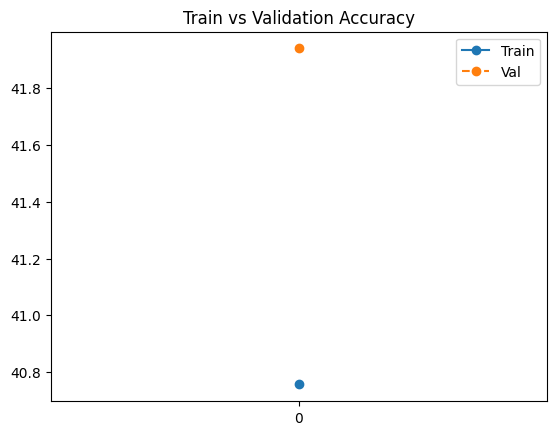

[2,   100] loss: 2.177
[2,   200] loss: 1.941
[2,   300] loss: 1.739
[2,   400] loss: 1.552
2 2.092154070779726
Training: Got accuracy 70.06
Validation: Got accuracy 70.77


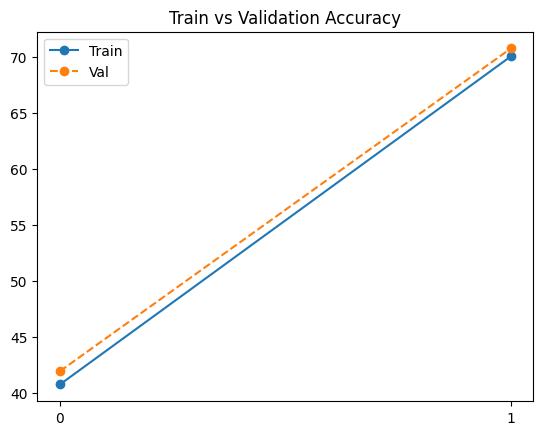

[3,   100] loss: 1.345
[3,   200] loss: 1.276
[3,   300] loss: 1.165
[3,   400] loss: 1.097
3 1.3984679652763916
Training: Got accuracy 81.55
Validation: Got accuracy 81.41


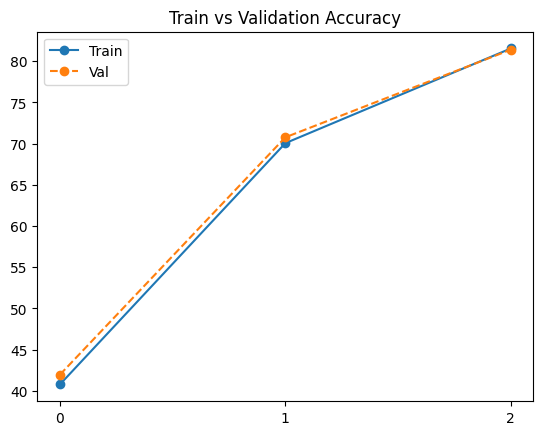

[4,   100] loss: 1.003
[4,   200] loss: 0.971
[4,   300] loss: 0.916
[4,   400] loss: 0.873
4 1.0865629135846375
Training: Got accuracy 86.85
Validation: Got accuracy 86.83


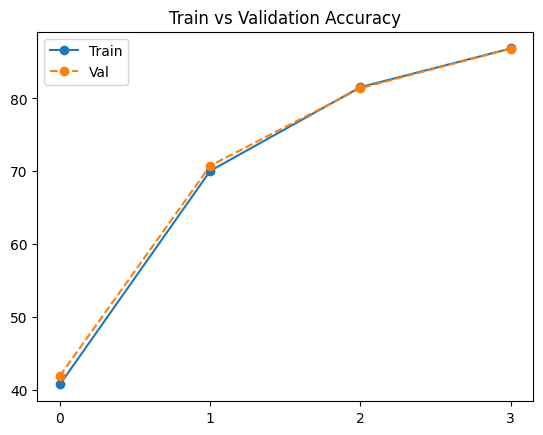

[5,   100] loss: 0.833
[5,   200] loss: 0.820
[5,   300] loss: 0.779
[5,   400] loss: 0.728
5 0.9151587922114868
Training: Got accuracy 90.75
Validation: Got accuracy 90.15


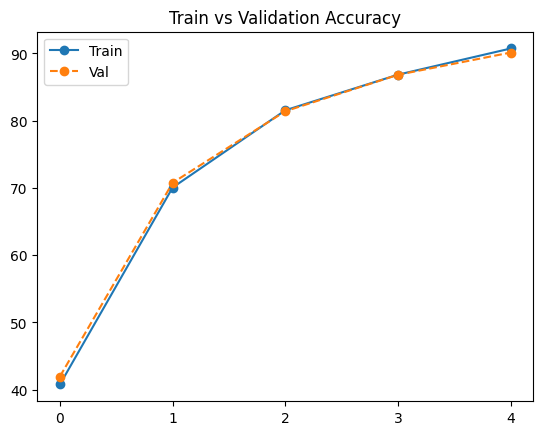

In [ ]:
train_acc = []
test_acc = []

for epoch in range(epochs):
  epoch_loss = 0.0
  running_loss = 0.0
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device)
    targets = targets.to(device)

    #forward
    scores = model(data)
    loss = criterion(scores, targets)

    #backward
    optimizer.zero_grad()
    loss.backward()

    #gradient descend
    optimizer.step()

    #loss while training
    epoch_loss += scores.shape[0] * loss.item()
    running_loss += loss.item()
    #print running loss
    if batch_idx % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 100))
            running_loss = 0.0

  #print epoch loss
  print(epoch+1, epoch_loss / len(train_dataset))

  t, ts = validation_vs_training(train_loader, test_loader, model)
  train_acc.append(t)
  test_acc.append(ts)
  print(f'Training: Got accuracy {train_acc[epoch]:.2f}')
  print(f'Test: Got accuracy {test_acc[epoch]:.2f}')


  plot_train_vs_validation(train_acc, test_acc, epoch + 1, "Train vs Validation Accuracy")


In [ ]:
model_save_name = 'CNN_100_dropout_05.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
torch.save(model.state_dict(), path)

# Evaluation method


In [ ]:
def eval_model(loader, model, plot = False, return_critical_points = False, return_accuracy = False):

  num_correct = 0
  num_samples = 0
  y_pred = []
  y_true = []
  model.eval()

  critical_points = []
  i = 0

  with torch.no_grad():
    for inputs, classes in loader:
      inputs = inputs.to(device=device)
      classes = classes.to(device=device)

      scores = model(inputs)
      _, predictions = scores.max(1)
      num_correct += (predictions == classes).sum()
      num_samples += predictions.size(0)

      #critical_points
      if return_critical_points:
        for j, p in enumerate(predictions):
          if not p == classes[j]:
            critical_points.append(i)
          i+=1

      if plot:
        outputs = (torch.max(torch.exp(scores), 1)[1]).data.cpu().numpy()
        y_pred.extend(outputs)
        classes = classes.data.cpu().numpy()
        y_true.extend(classes)

    if return_accuracy:
      return float(num_correct)/float(num_samples)*100
    else:
      print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    if plot:
      cm = confusion_matrix(y_true, y_pred)
      df_cm = pd.DataFrame(cm / np.sum(cm, axis=1)[:, None])
      plt.figure(figsize = (30,15))
      sn.heatmap(df_cm, annot=True)
      plt.show()

  model.train()

  if return_critical_points:
    return critical_points


Got 31331 / 31416 with accuracy 99.73
Got 3872 / 3927 with accuracy 98.60
Got 3872 / 3927 with accuracy 98.60


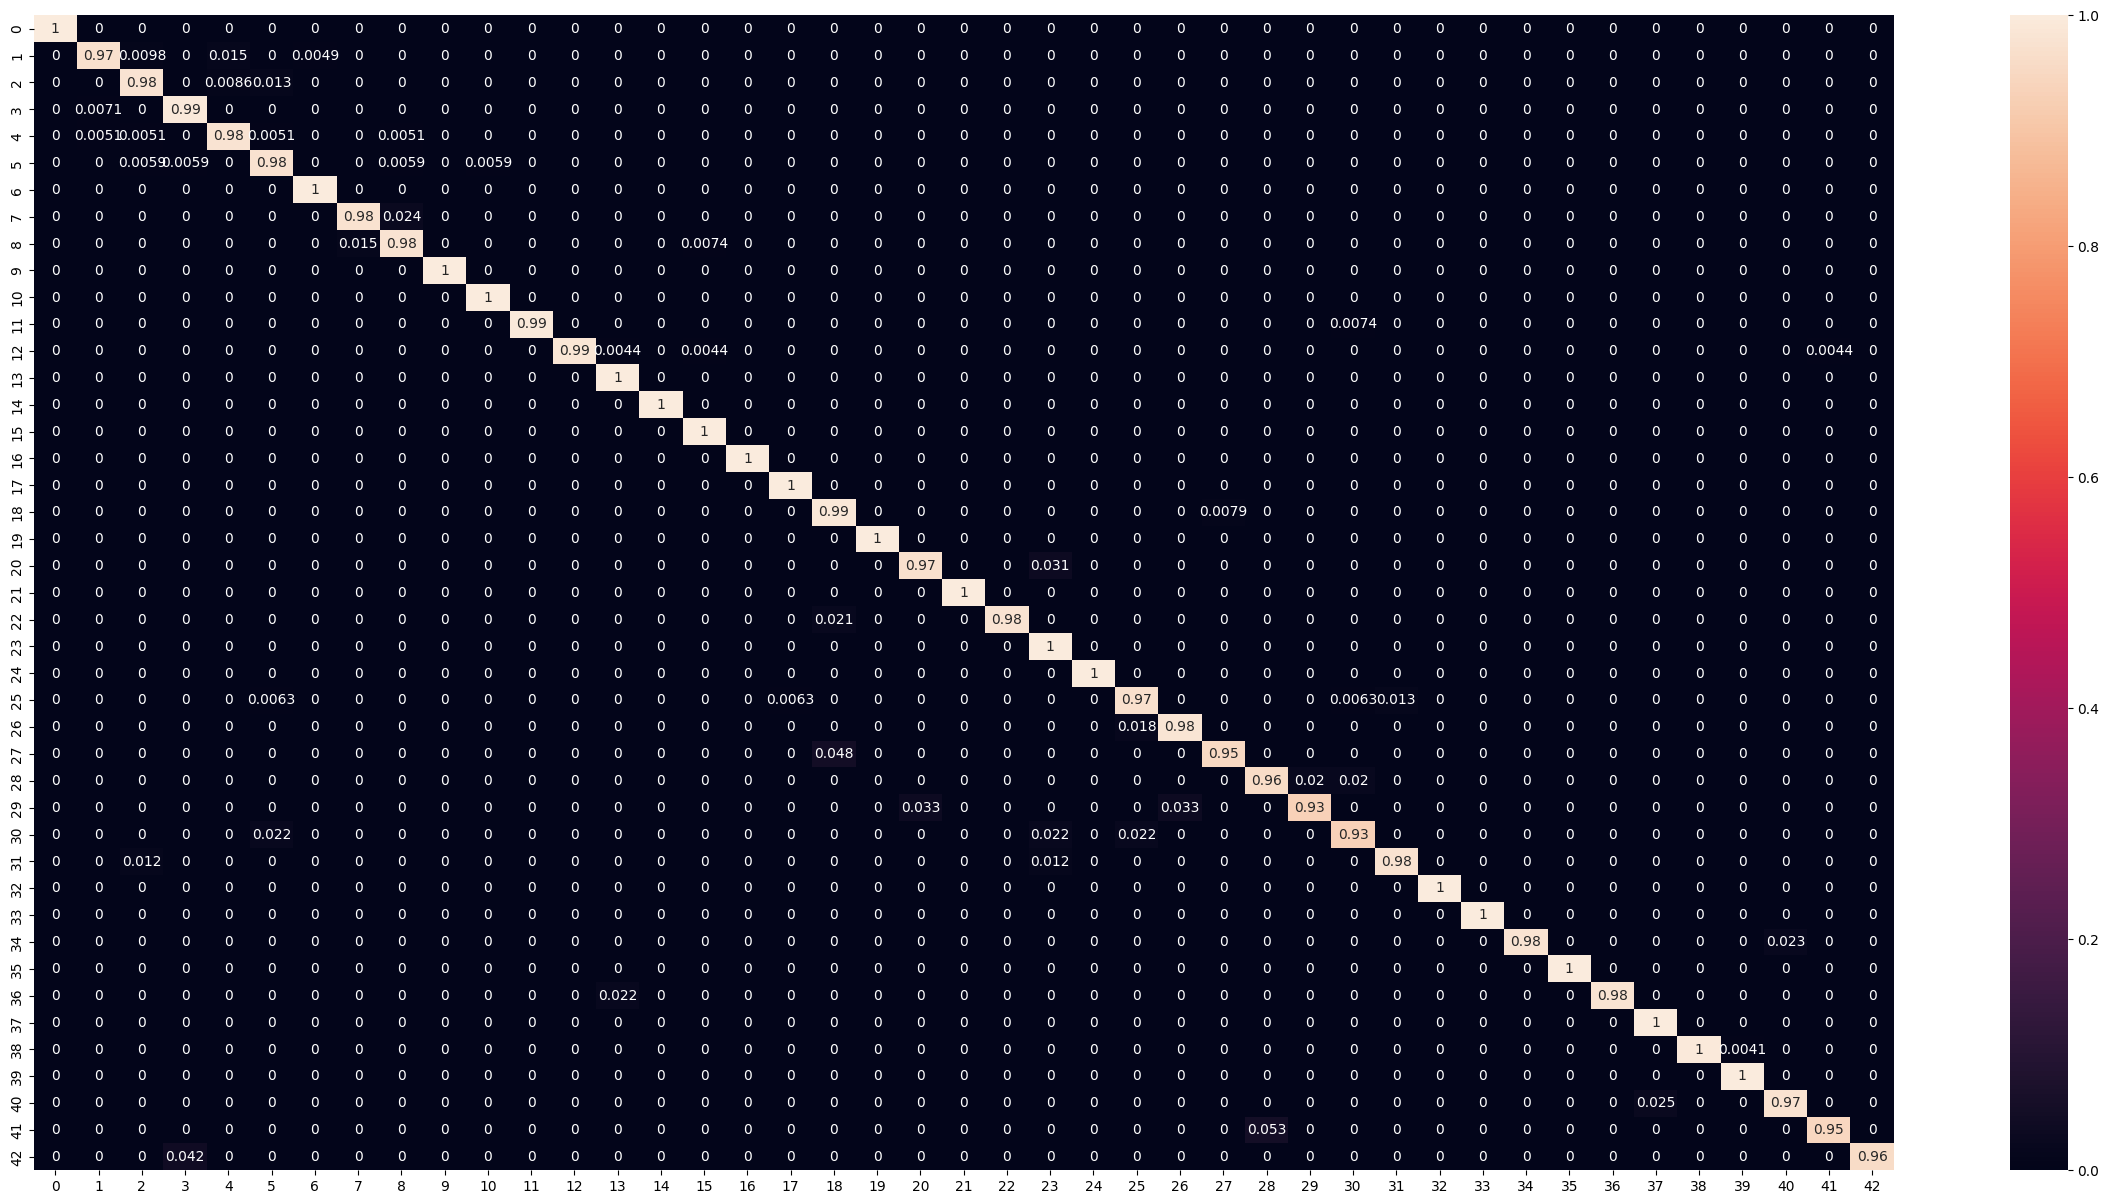

Got 3872 / 3927 with accuracy 98.60
[0, 86, 208, 295, 299, 315, 344, 384, 418, 724, 744, 829, 834, 860, 900, 917, 1036, 1076, 1148, 1169, 1235, 1285, 1423, 1460, 1463, 1497, 1628, 1720, 1785, 1839, 2072, 2078, 2107, 2144, 2264, 2271, 2285, 2311, 2604, 2620, 2638, 2702, 2767, 2816, 3025, 3203, 3312, 3323, 3492, 3509, 3523, 3568, 3702, 3812, 3858]
98.59943977591037


In [ ]:
eval_model(train_loader, model)
eval_model(test_loader, model)
eval_model(test_loader, model, plot = True)
accuracy = eval_model(test_loader, model, return_accuracy = True)
critical_points = eval_model(test_loader, model, return_critical_points = True)
print(critical_points)
print(accuracy)

# Data methods


In [ ]:
def get_distribution(loader):
  distribution = [0 for i in range(num_classes)]
  for data, target in loader:
    for y in target:
      distribution[y] +=1
  return distribution

In [ ]:
def plot_distribution(dist, labels, title = ""):
  plt.rcdefaults()
  plt.figure(figsize=(20,6))
  plt.title(title)
  plt.xticks(range(len(labels)), labels, rotation=90)
  x = [i for i in range(len(labels))]

  plt.bar(x, dist)
  plt.show()

In [ ]:
def plot_relative_distribution(dist, total_dist, labels, title = ""):
  plt.rcdefaults()
  new_dist = []

  label_index = []
  for i, td in enumerate(total_dist):
    if td != 0:
      new_dist.append(dist[i] / td)
      label_index.append(i)

  plt.figure(figsize=(20,6))
  plt.title(title)

  if len(labels) == len(label_index):
    plt.xticks([i for i in range(len(labels))], labels, rotation=90)
    x = [i for i in range(len(labels))]
  else:
    labels_subset = []
    for idx in label_index:
      labels_subset.append(labels[idx])

    plt.xticks([i for i in range(len(labels_subset))], labels_subset, rotation = 90)
    x = [i for i in range(len(labels_subset))]
  plt.plot(x, new_dist)
  plt.show()

In [ ]:
total_loader = DataLoader(dataset = dataset, batch_size = len(dataset), shuffle = False)
total_dist = get_distribution(total_loader)

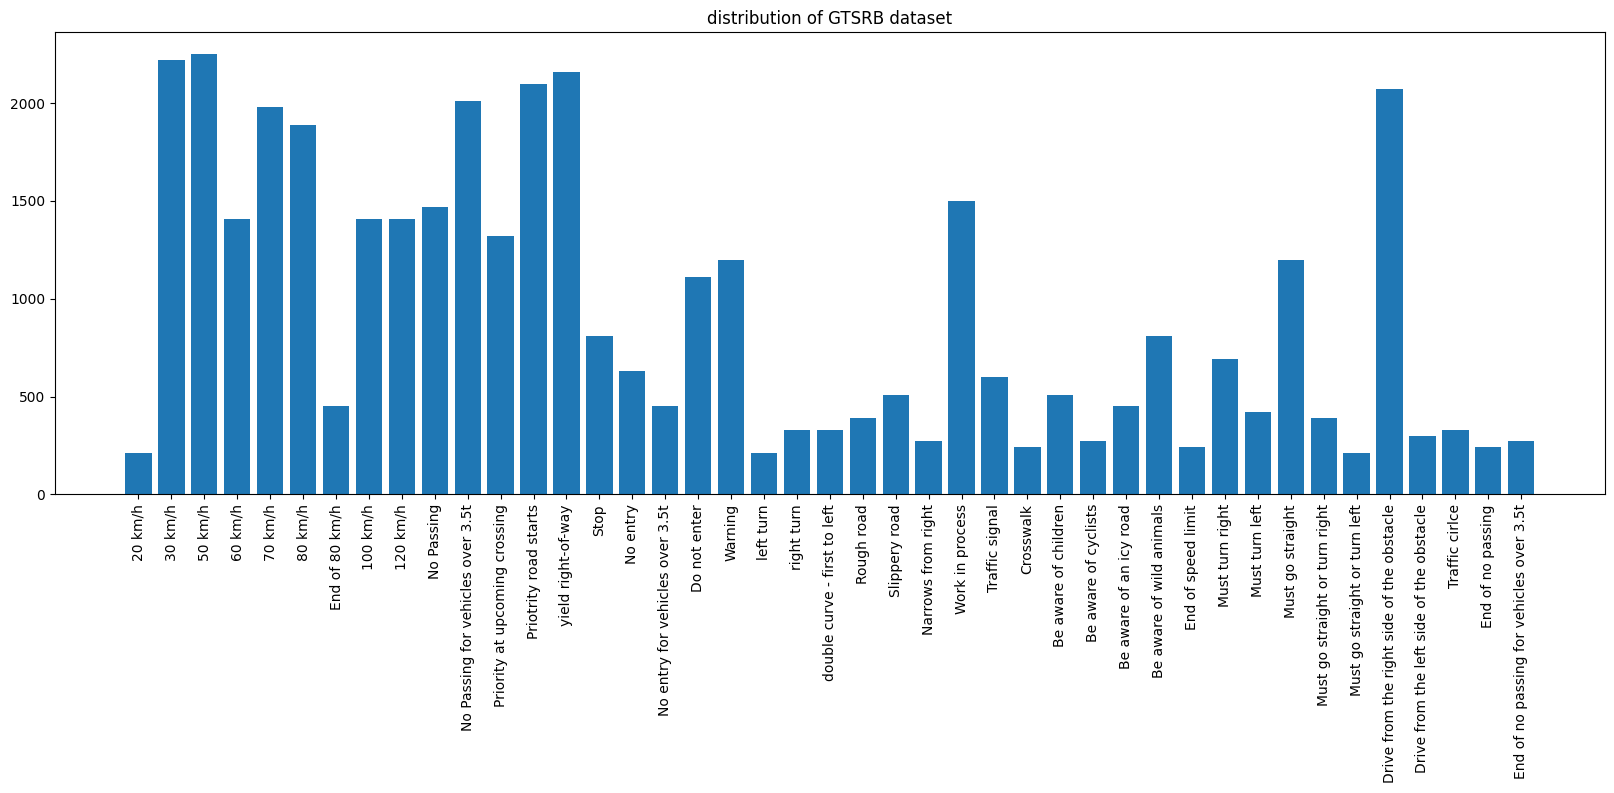

In [ ]:
plot_distribution(total_dist, labels, "distribution of GTSRB dataset")

# Calibration


In [ ]:
cal_loader = DataLoader(dataset = calset, batch_size = len(calset), shuffle = False)
cal_dist = get_distribution(cal_loader)

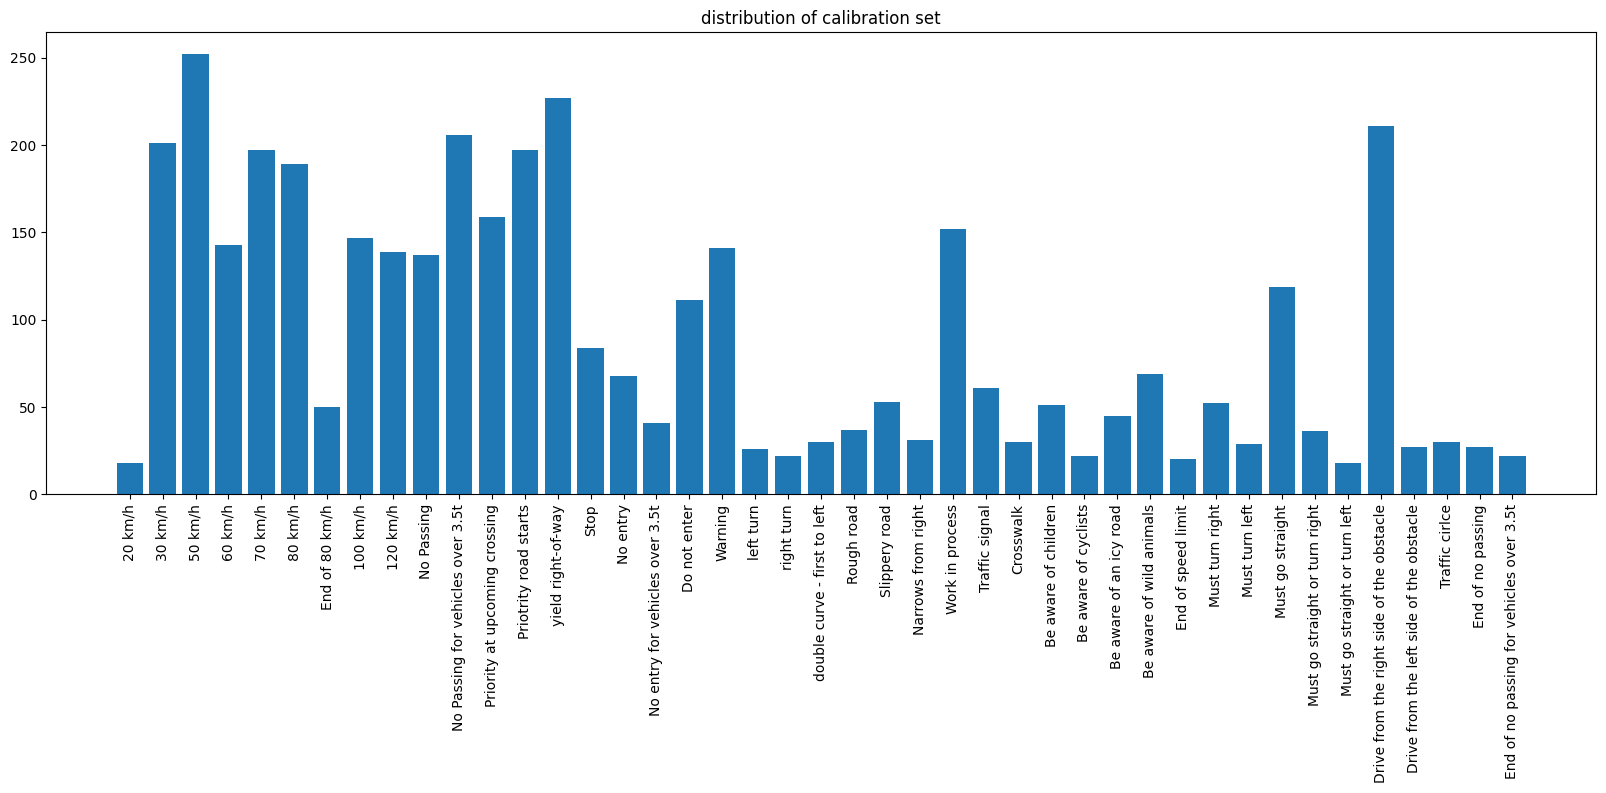

In [ ]:
plot_distribution(cal_dist, labels, "distribution of calibration set")

In [ ]:
n_cal = len(calset)

In [ ]:
softm = nn.Softmax(dim = 1)

In [ ]:
def get_smx_and_labels(loader):
  smx = []
  true_labels = []
  for data, target in loader:
    data = data.to(device = device)
    target = target.to(device = device)

    #get softmax(smx) values for all 43 classes
    out = model(data)
    smx_scores = softm(out)
    smx_scores = smx_scores.cpu().data.numpy()

    for array in smx_scores:
      a = array.tolist()
      smx.append(a)

    #get true class
    for label in target:
      label = label.item()
      true_labels.append(label)

  return np.array(smx), np.array(true_labels)

In [ ]:
def calc_scores(cal_smx, cal_true_labels):
  return 1-cal_smx[np.arange(n_cal),cal_true_labels]

In [ ]:
def calc_qhat(cal_loader, alpha):
  cal_smx, cal_true_labels = get_smx_and_labels(cal_loader)
  cal_scores = calc_scores(cal_smx, cal_true_labels)
  q_level = np.ceil((n_cal+1)* (1-alpha))/n_cal
  q_hat = np.quantile(cal_scores, q_level, interpolation= 'higher')
  return q_hat

In [ ]:
def get_prediction_sets(data_smx, q_hat):
  return data_smx >= (1-q_hat)

In [ ]:
def get_average_prediction_set_size(idx, prediction_sets):

  avg = 0.0
  for i in idx:
    prediction_set = np.array(prediction_sets[i])
    avg += prediction_set.sum()
  avg = avg / len(idx)
  return avg


In [ ]:
def get_in_set(prediction_set, true_label_id):
  return prediction_set[true_label_id]

In [ ]:
def get_sorted_prediction_set(prediction_set, data_smx, img_id):

  lst = []

  for i, b in enumerate(prediction_set):
    if b:
      t = (data_smx[img_id,i], i)
      lst.append(t)
  lst.sort(key=lambda tup: tup[0], reverse = True)
  return lst

In [ ]:
def plot_alpha_vs_setsize(alphas, data_smx, dataset):
  plt.rcdefaults()
  avgs = []
  for a in alphas:
    q_h = calc_qhat(cal_loader, a)
    prediction_sets = get_prediction_sets(data_smx, q_h)
    avg = get_average_prediction_set_size(range(len(dataset)), prediction_sets)
    avgs.append(avg)
  plt.title("error rate vs set size", fontsize = 25)
  plt.xlabel("alpha", fontsize = 25)
  plt.ylabel("average set size", fontsize = 25)
  plt.plot(alphas, avgs)
  plt.yticks(np.arange(0,10,1), ["", "1", "", "3", "", "5", "", "7", "", "9"])
  plt.tick_params(axis='y', labelsize=20)
  plt.tick_params(axis='x', labelsize=20)
  plt.grid()
  plt.show()

In [ ]:
def visualize_calibration(cal_smx, cal_true_labels, scores, labels,  q_hat):
  plt.rcdefaults()
  m = 0
  img_id = 0
  prediction_sets = get_prediction_sets(cal_smx, q_hat)

  for i , p_set in enumerate(prediction_sets):
    if p_set.sum() in [6,7,8,9]:
      m = p_set.sum()
      img_id = i
  if img_id == 0:
    print("rip")
    for i , p_set in enumerate(prediction_sets):
      if p_set.sum() > m:
        m = p_set.sum()
        img_id = i

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 6), )
  fig.suptitle('Conformal prediction', fontsize = 35)

  ax1.set_xticks([])
  ax1.tick_params(axis='y', labelsize=20)
  ax1.set_yscale("log")
  ax1.set_xlabel("classes", fontsize = 25)
  ax1.set_ylabel("softmax", fontsize = 25)
  x = [i for i in range(len(labels))]
  ax1.bar(x, cal_smx[img_id])[cal_true_labels[img_id]].set_color('r')
  ax1.axhline(y = 1 - scores[img_id], color = 'r', linestyle = '--', label = "1 - true_smx")
  ax1.legend(bbox_to_anchor = (0.85, 0.9), loc = 'upper center',prop={"size":16})

  ax2.set_xticks([])
  ax2.set_yscale("log")
  ax2.tick_params(axis='y', labelsize=20)
  ax2.set_ylabel("softmax", fontsize = 25)
  ax2.set_xlabel("classes", fontsize = 25)
  x = [i for i in range(len(labels))]
  bar = ax2.bar(x, cal_smx[img_id])
  for i, b in enumerate(prediction_sets[img_id]):
    if b:
      bar[i].set_color('c')
  bar[cal_true_labels[img_id]].set_color('r')
  ax2.axhline(y = 1 - q_hat, color = 'r', linestyle = '--', label = "1 - q_hat")
  ax2.legend(bbox_to_anchor = (0.9, 0.95), loc = 'upper center',prop={"size":16})


In [ ]:
cal_smx, cal_true_labels, = get_smx_and_labels(cal_loader)
scores = calc_scores(cal_smx, cal_true_labels)

In [ ]:
q_hat = calc_qhat(cal_loader, 0.005)

<ipython-input-39-ab075ffb1536>:5: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  q_hat = np.quantile(cal_scores, q_level, interpolation= 'higher')


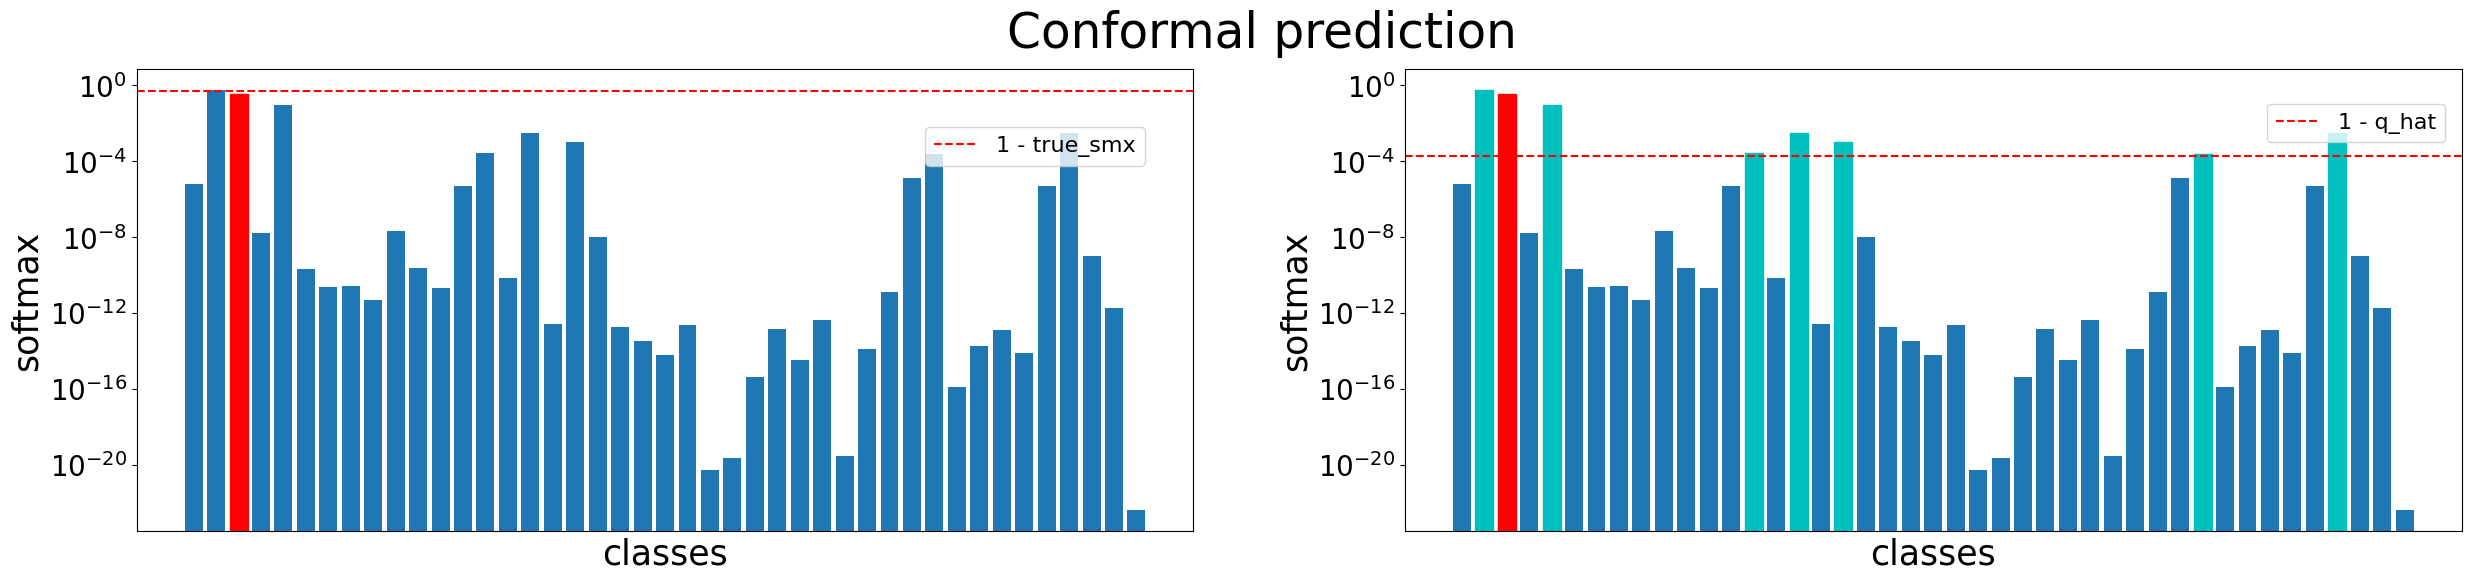

In [ ]:
test_smx, test_true_labels = get_smx_and_labels(test_loader)
visualize_calibration(test_smx, test_true_labels, scores, labels, q_hat)

<ipython-input-39-ab075ffb1536>:5: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  q_hat = np.quantile(cal_scores, q_level, interpolation= 'higher')


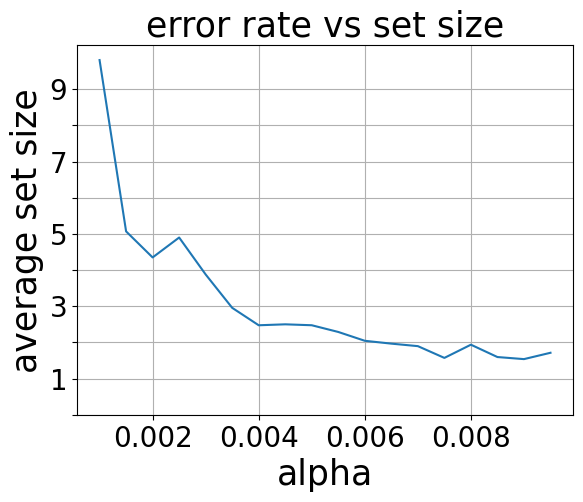

In [ ]:
test_smx, _ = get_smx_and_labels(test_loader)
alphas = np.arange(0.001, 0.01, 0.0005)
plot_alpha_vs_setsize(alphas, test_smx, testset)

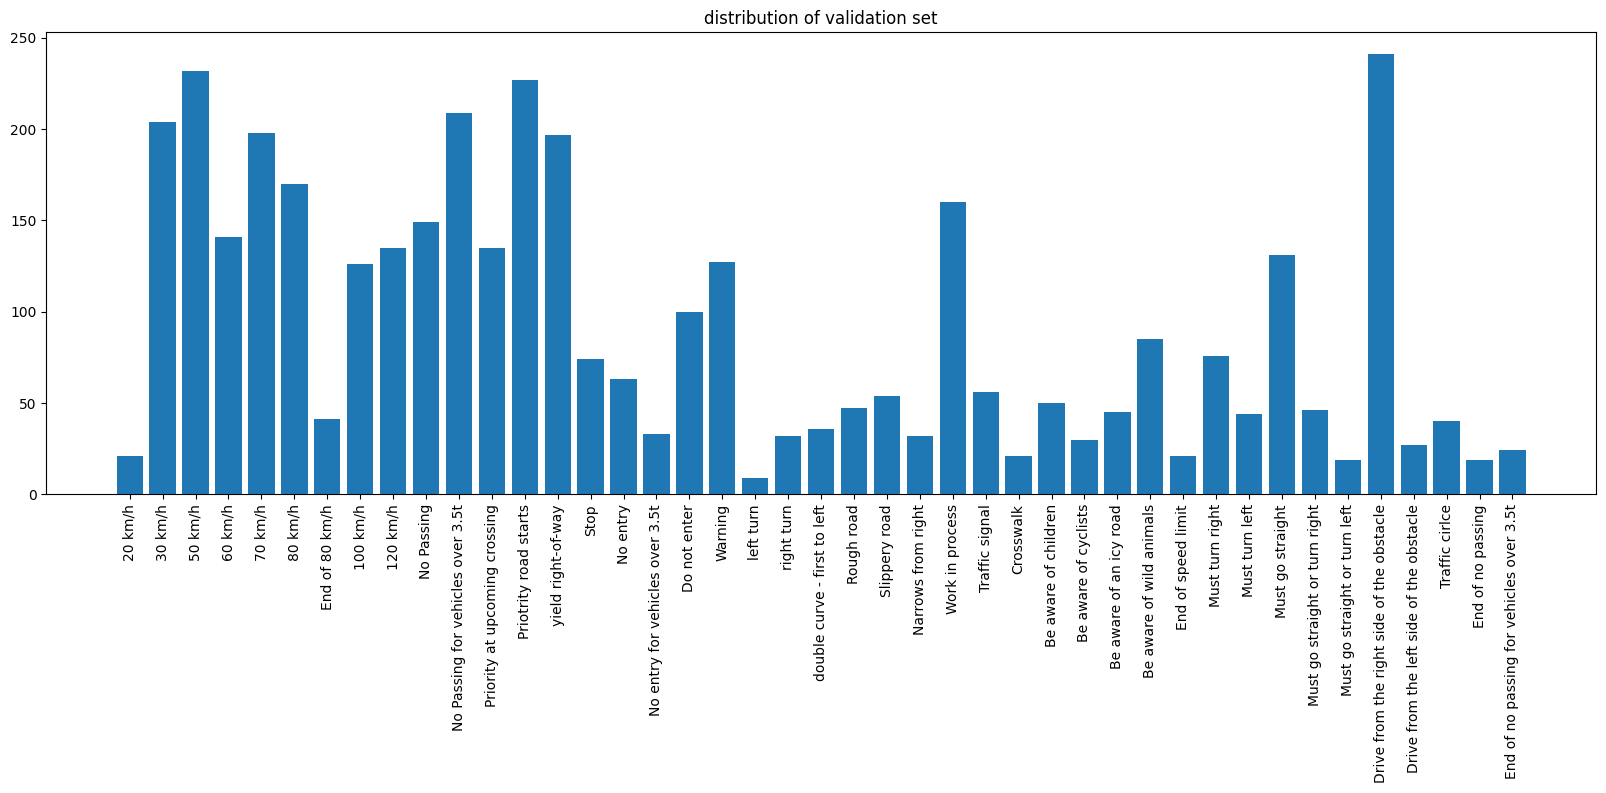

In [ ]:
test_dist = get_distribution(test_loader)
plot_distribution(test_dist, labels, "distribution of validation set")

# Conformal prediction function




In [ ]:
def conformal_prediction(idx, data, data_smx, show_img = True, print_set = True):

  in_set_distribution = [0 for i in range(num_classes)]
  not_in_set_distribution = [0 for i in range(num_classes)]

  prediction_sets = get_prediction_sets(data_smx, q_hat)
  in_set = 0.0

  for i in idx:
    img, true_label_id = data[i]

    if show_img:
      plt.title(labels[true_label_id])
      plt.axis("off")
      img = img.swapaxes(0,1)
      img = img.swapaxes(1,2)
      plt.imshow(img.squeeze(), cmap="gray")
      plt.show()

    prediction_set = prediction_sets[i]

    if print_set:
      if get_in_set(prediction_set, true_label_id):
        s = Fore.GREEN + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
      else:
        s = Fore.RED + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
    t = True

    sorted_prediction_set = get_sorted_prediction_set(prediction_set, data_smx, i)

    for (smx, index) in sorted_prediction_set:

      label_string = labels[index]

      if label_string == labels[true_label_id]:
        if print_set:
          label_string = Style.BRIGHT + Fore.YELLOW + labels[index] + Style.RESET_ALL + Fore.WHITE

      if print_set:
        if t:
          s = s + label_string + ": " + str(smx)
          t = False
        else:
          s = s + ", " + label_string + ": " + str(smx)

    if prediction_set[true_label_id]:
      in_set_distribution[true_label_id] += 1
      in_set += 1.0
    else:
      not_in_set_distribution[true_label_id] += 1

    if print_set:
      if show_img:
        print(s+"}")
      else:
        space = ""
        for i in range(50 - len(labels[true_label_id])):
          space += " "
        print(labels[true_label_id] + space + s+"}")
  print("_________________________________________________________________________________________")
  print("We have the probability of "+ Fore.RED + str(in_set/len(idx)) + Style.RESET_ALL +" that the true label is in the prediction set with an average prediction set size of "+ Fore.RED + str(get_average_prediction_set_size(idx, prediction_sets)) + Style.RESET_ALL)

  return in_set_distribution, not_in_set_distribution

# Conformal prediction for critical data points i.e. data points that the model did not predict right.


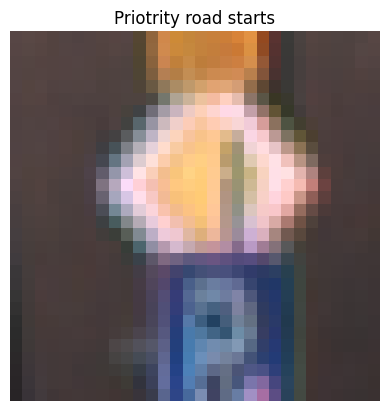

prediction set: {End of no passing: 0.5354415774345398, Must go straight: 0.3579513728618622, No Passing: 0.08234752714633942, yield right-of-way: 0.016101885586977005, End of speed limit: 0.0063557312823832035, Priotrity road starts: 0.0010774951661005616, Must go straight or turn right: 0.0004691781650763005}


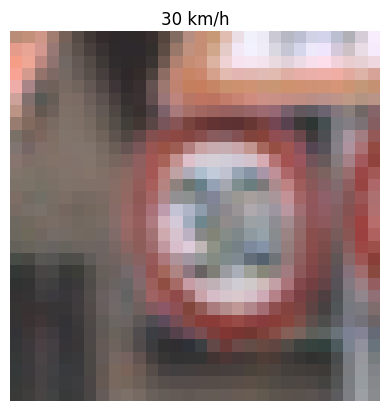

prediction set: {30 km/h: 0.7876655459403992, 20 km/h: 0.1462630033493042, 70 km/h: 0.06607091426849365}


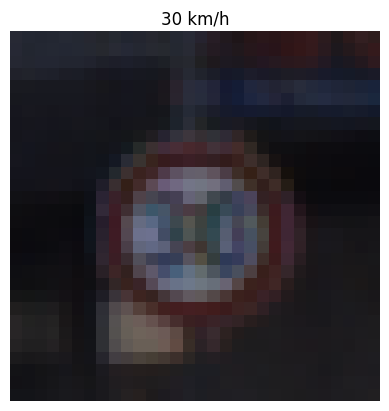

prediction set: {50 km/h: 0.7890530228614807, 70 km/h: 0.19963249564170837, 30 km/h: 0.011231005191802979}


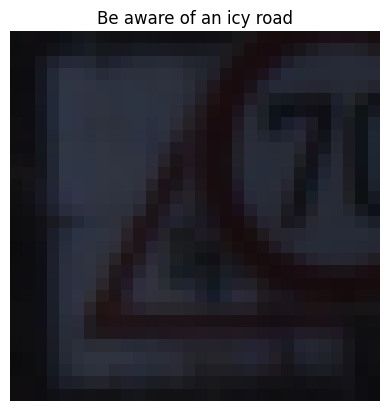

prediction set: {Work in process: 0.7225804924964905, Be aware of wild animals: 0.1554005891084671, Narrows from right: 0.02606142684817314, Be aware of an icy road: 0.016725175082683563, Priotrity road starts: 0.010205845348536968, 30 km/h: 0.009815970435738564, left turn: 0.007134841289371252, 50 km/h: 0.006716739386320114, Warning: 0.005998557899147272, Traffic signal: 0.005642100237309933, Be aware of cyclists: 0.005633078515529633, Must turn right: 0.005276885349303484, Slippery road: 0.0034173205494880676, 70 km/h: 0.0027831336483359337, Do not enter: 0.002634915988892317, No Passing for vehicles over 3.5t: 0.0022105781827121973, double curve - first to left: 0.0019340399885550141, Drive from the right side of the obstacle: 0.0018617510795593262, yield right-of-way: 0.0016277506947517395, Stop: 0.0012595183216035366, Priority at upcoming crossing: 0.001188764232210815, 80 km/h: 0.0009391965577378869, right turn: 0.0006915736594237387, 60 km/h: 0.00046913675032556057, Crosswalk: 0

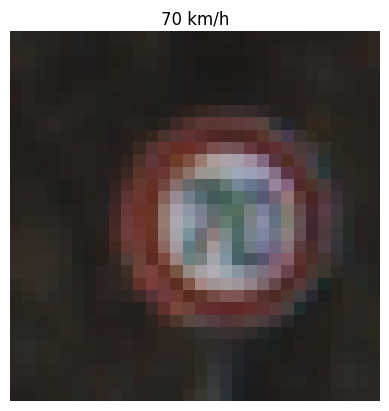

prediction set: {70 km/h: 0.9966092109680176, Do not enter: 0.003210802562534809}


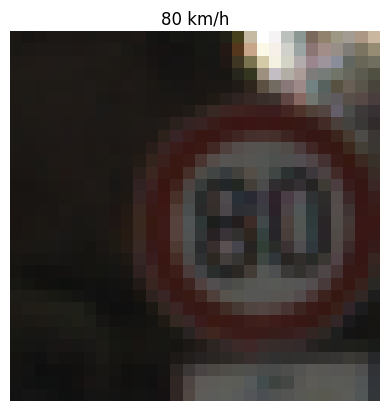

prediction set: {120 km/h: 0.9203152060508728, 80 km/h: 0.022038454189896584, Be aware of children: 0.016556890681385994, No entry: 0.01640026643872261, 60 km/h: 0.015791570767760277, right turn: 0.0033898295368999243, 100 km/h: 0.0012170406989753246, Stop: 0.0010846087243407965, Must go straight: 0.0006199878989718854, No entry for vehicles over 3.5t: 0.0005429528537206352, Rough road: 0.00038274197140708566, yield right-of-way: 0.0003064322518184781, Be aware of cyclists: 0.0002867307630367577, No Passing: 0.00027884216979146004, Slippery road: 0.00026470934972167015, No Passing for vehicles over 3.5t: 0.0002318310143891722}


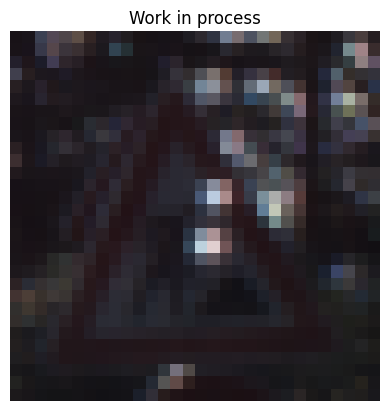

prediction set: {Work in process: 0.8223437070846558, Drive from the right side of the obstacle: 0.08439371734857559, 80 km/h: 0.042652279138565063, Rough road: 0.03225594013929367, No Passing for vehicles over 3.5t: 0.013745028525590897, right turn: 0.003630985738709569, Be aware of wild animals: 0.0008206291240639985}


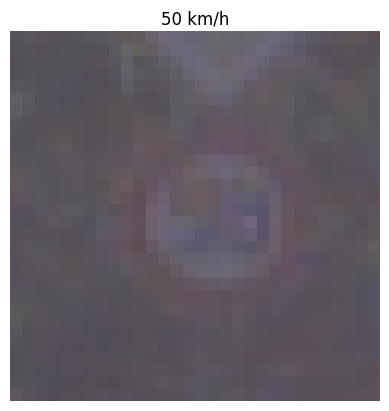

prediction set: {30 km/h: 0.6210215091705322, 50 km/h: 0.28513258695602417, 70 km/h: 0.061792388558387756, Do not enter: 0.01592434011399746, No entry: 0.013252822682261467, Drive from the left side of the obstacle: 0.0021553889382630587, yield right-of-way: 0.0002482651616446674, Must turn right: 0.00020630218205042183}


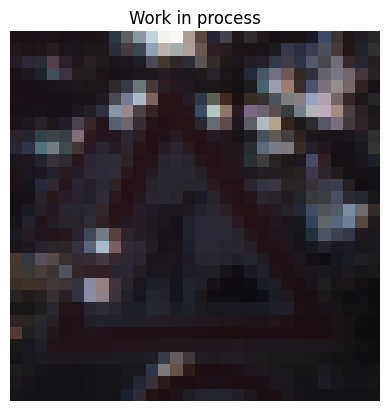

prediction set: {No entry: 0.6019045114517212, Work in process: 0.23096022009849548, Do not enter: 0.13773462176322937, yield right-of-way: 0.02868562377989292, Priotrity road starts: 0.0005815967451781034}


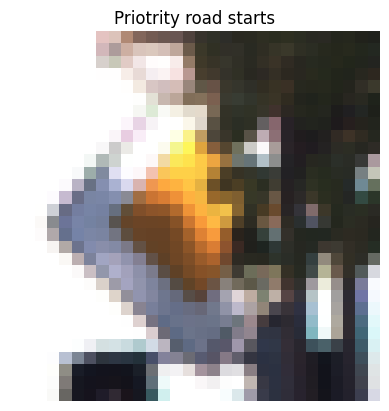

prediction set: {No Passing: 0.9865655303001404, Be aware of children: 0.013156195171177387, yield right-of-way: 0.00027219951152801514}


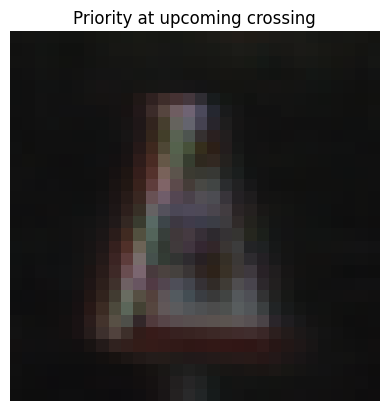

prediction set: {Be aware of children: 0.7468733191490173, Priority at upcoming crossing: 0.11539440602064133, No entry for vehicles over 3.5t: 0.04174003377556801, End of no passing: 0.030439896509051323, Traffic cirlce: 0.025598762556910515, Must go straight: 0.02103348635137081, right turn: 0.0060756574384868145, Be aware of an icy road: 0.006002371199429035, Crosswalk: 0.002510017715394497, End of speed limit: 0.001646042219363153, 100 km/h: 0.0010478554759174585, End of no passing for vehicles over 3.5t: 0.0007537579513154924, No Passing: 0.0006460368167608976}


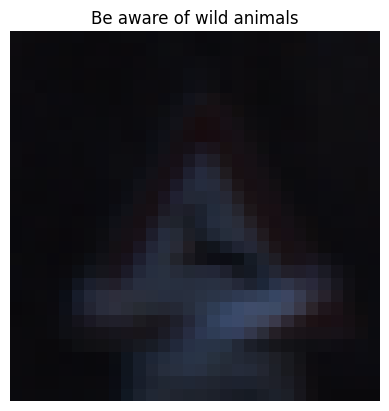

prediction set: {80 km/h: 0.36337462067604065, left turn: 0.28151124715805054, Slippery road: 0.10287231206893921, Be aware of wild animals: 0.0889686644077301, End of 80 km/h: 0.08207309991121292, 50 km/h: 0.05411996692419052, No entry for vehicles over 3.5t: 0.008576779626309872, 60 km/h: 0.006332652643322945, right turn: 0.006121724843978882, 100 km/h: 0.002124116523191333, 30 km/h: 0.0008912039920687675, End of no passing for vehicles over 3.5t: 0.0007339406292885542, No Passing for vehicles over 3.5t: 0.0005436345818452537, double curve - first to left: 0.000531801488250494, Be aware of an icy road: 0.00038615550147369504, 70 km/h: 0.00029176773387007415}


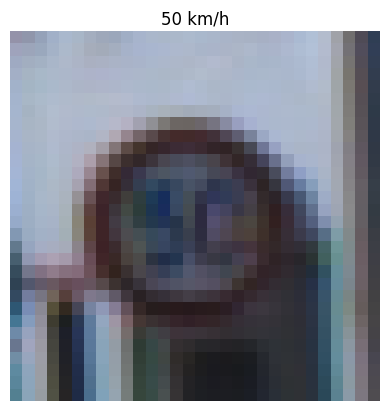

prediction set: {80 km/h: 0.91170334815979, 100 km/h: 0.08444467186927795, 60 km/h: 0.001953922212123871, No Passing for vehicles over 3.5t: 0.0018855544039979577}


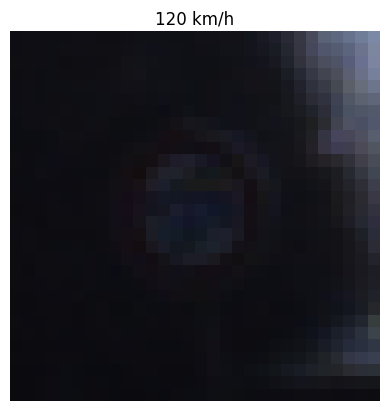

prediction set: {No entry: 0.7297243475914001, 60 km/h: 0.23073458671569824, 20 km/h: 0.011062719859182835, Stop: 0.010799075476825237, Be aware of children: 0.0070391991175711155, 120 km/h: 0.0036131793167442083, 80 km/h: 0.0020193932577967644, No Passing: 0.001257099094800651, yield right-of-way: 0.00119695661123842, Must turn right: 0.0004135332419537008, Do not enter: 0.0003945393254980445, 50 km/h: 0.0003165303496643901, right turn: 0.00029015273321419954, Must go straight: 0.000275494996458292, No entry for vehicles over 3.5t: 0.00025007445947267115, End of speed limit: 0.0002358307538088411}


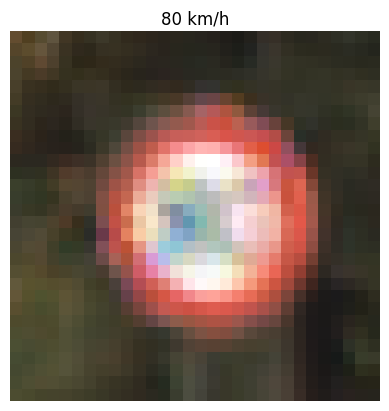

prediction set: {50 km/h: 0.9999183416366577}


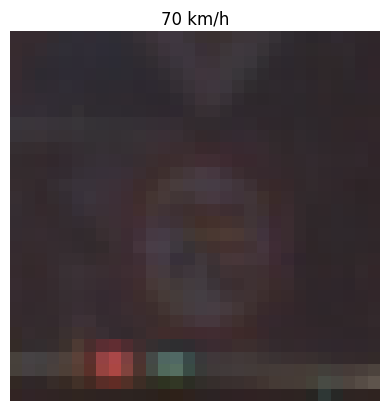

prediction set: {30 km/h: 0.4346010684967041, 70 km/h: 0.30883365869522095, Be aware of wild animals: 0.1413082629442215, 50 km/h: 0.07285452634096146, 20 km/h: 0.021454347297549248, End of 80 km/h: 0.012895900756120682, double curve - first to left: 0.003886554390192032, 80 km/h: 0.00282164360396564, 100 km/h: 0.000900792598258704, Priority at upcoming crossing: 0.0002359929058002308}


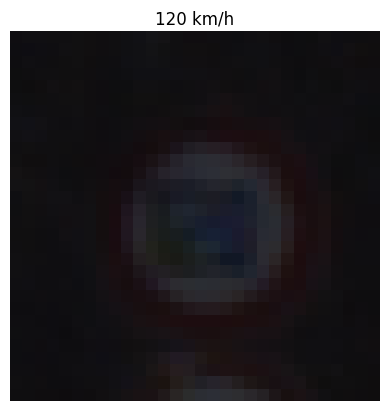

prediction set: {120 km/h: 0.7451002597808838, 100 km/h: 0.2320978194475174, 80 km/h: 0.02233930490911007, No entry for vehicles over 3.5t: 0.0002491014020051807}


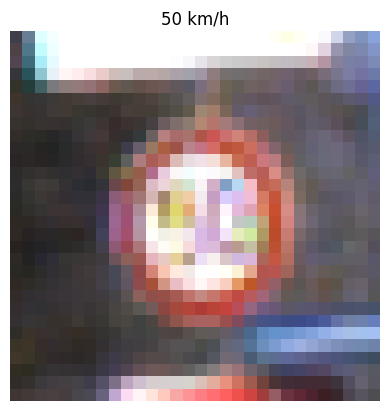

prediction set: {70 km/h: 0.8449124097824097, 30 km/h: 0.15478837490081787, 50 km/h: 0.000218484754441306}


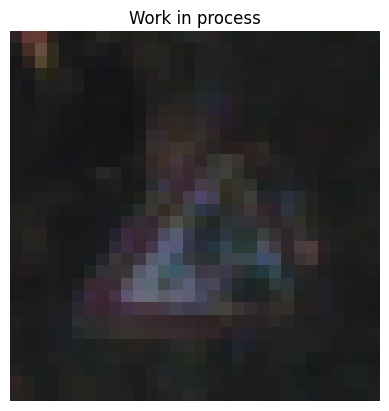

prediction set: {double curve - first to left: 0.5633657574653625, Work in process: 0.341714084148407, Be aware of wild animals: 0.0426514707505703, Priority at upcoming crossing: 0.03352917358279228, Drive from the right side of the obstacle: 0.013315344229340553, Be aware of an icy road: 0.0034809221979230642, Priotrity road starts: 0.0015497234417125583, Narrows from right: 0.00024996139109134674}


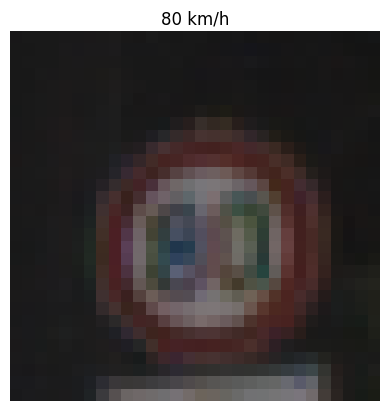

prediction set: {80 km/h: 0.959536075592041, 60 km/h: 0.04046391323208809}


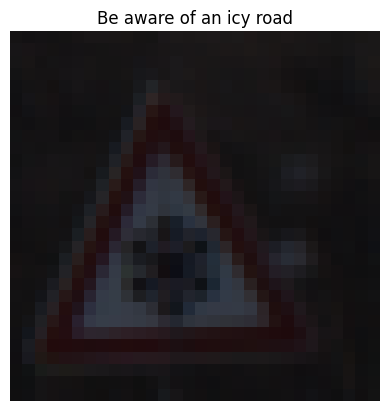

prediction set: {left turn: 0.23368902504444122, Slippery road: 0.18323135375976562, Be aware of wild animals: 0.17788754403591156, Be aware of an icy road: 0.09780830889940262, Work in process: 0.0894385352730751, right turn: 0.061673134565353394, 80 km/h: 0.04564961418509483, double curve - first to left: 0.022088905796408653, Narrows from right: 0.014755592681467533, End of 80 km/h: 0.012785669416189194, Be aware of cyclists: 0.009417620487511158, 60 km/h: 0.008408878929913044, Drive from the right side of the obstacle: 0.0071621243841946125, No Passing for vehicles over 3.5t: 0.005695078521966934, Must turn left: 0.004590671043843031, Must turn right: 0.004525281023234129, yield right-of-way: 0.0035297702997922897, Priority at upcoming crossing: 0.003289161715656519, Must go straight or turn left: 0.0023415067698806524, End of no passing for vehicles over 3.5t: 0.0014624044997617602, Rough road: 0.0014207091880962253, 50 km/h: 0.0014115317026153207, Warning: 0.00109222368337214, No

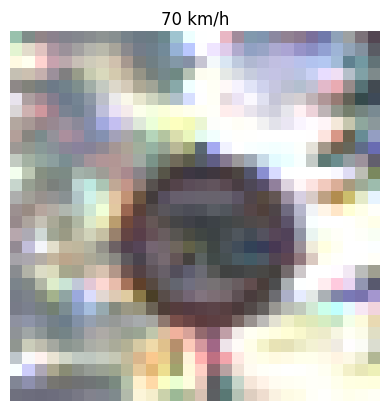

prediction set: {70 km/h: 0.9310299754142761, 120 km/h: 0.05973825976252556, 50 km/h: 0.008835193701088428, 80 km/h: 0.00033987456117756665}


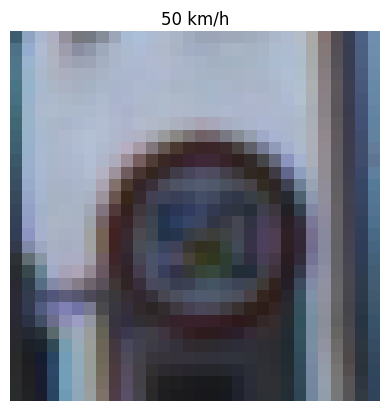

prediction set: {80 km/h: 0.9939975738525391, 120 km/h: 0.00554482638835907, 100 km/h: 0.00041031971340999007}


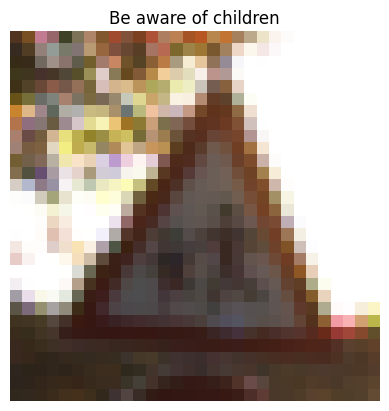

prediction set: {Slippery road: 0.5305821895599365, Be aware of children: 0.2126787304878235, right turn: 0.18943406641483307, Be aware of an icy road: 0.045483771711587906, Be aware of cyclists: 0.021059412509202957, Rough road: 0.0007616706425324082}


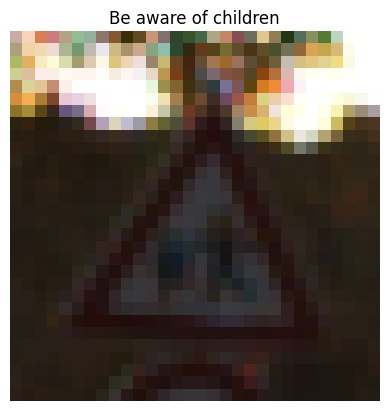

prediction set: {Be aware of an icy road: 0.9023767709732056, right turn: 0.0828716829419136, Be aware of children: 0.0050892154686152935, Work in process: 0.004952461924403906, Narrows from right: 0.004173888824880123, Slippery road: 0.0003613363951444626}


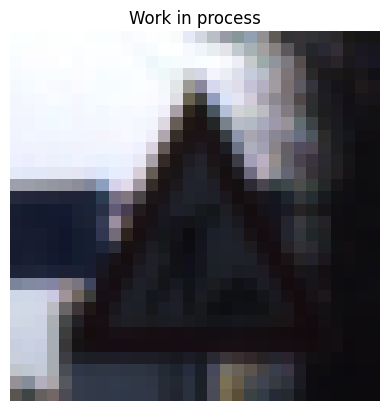

prediction set: {Work in process: 0.37726661562919617, Warning: 0.27030059695243835, No entry for vehicles over 3.5t: 0.14553095400333405, right turn: 0.12398388981819153, Be aware of an icy road: 0.05426309257745743, 120 km/h: 0.00976452138274908, 100 km/h: 0.007090630941092968, Priority at upcoming crossing: 0.004814231302589178, Narrows from right: 0.0024670474231243134, Must turn right: 0.0015813085483387113, Drive from the right side of the obstacle: 0.000689381908159703, Must turn left: 0.0006305019487626851, Crosswalk: 0.0004110792651772499, 80 km/h: 0.0003308177983853966}


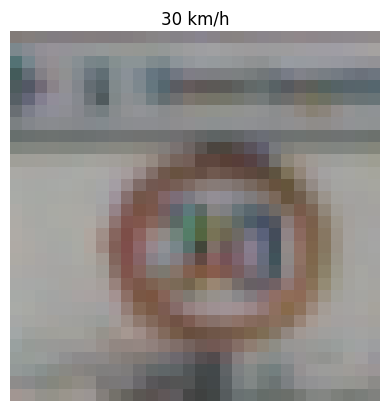

prediction set: {30 km/h: 0.7656131982803345, 50 km/h: 0.23438678681850433}


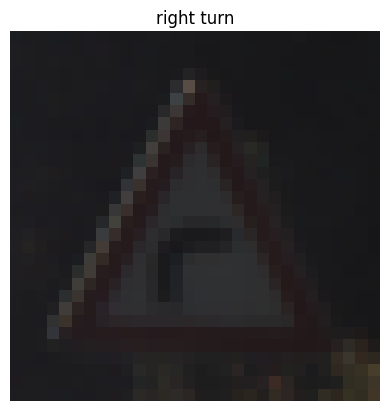

prediction set: {Slippery road: 0.5599299669265747, right turn: 0.3121423125267029, No Passing for vehicles over 3.5t: 0.08233843743801117, No Passing: 0.019986070692539215, 60 km/h: 0.013622668571770191, 80 km/h: 0.0055655548349022865, End of no passing for vehicles over 3.5t: 0.004396846052259207, Must turn left: 0.0009972210973501205, Must go straight: 0.0004060265782754868, No entry for vehicles over 3.5t: 0.00021819729590788484}


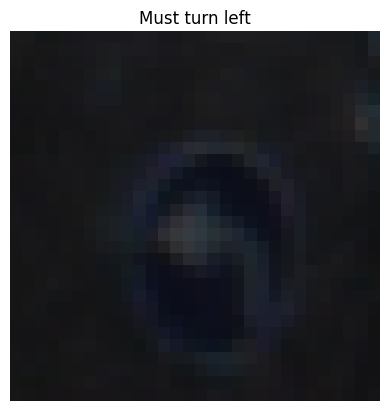

prediction set: {Traffic cirlce: 0.4146868884563446, End of 80 km/h: 0.28054144978523254, Must turn left: 0.12348788231611252, End of no passing for vehicles over 3.5t: 0.09030435234308243, Be aware of an icy road: 0.03547266870737076, No entry for vehicles over 3.5t: 0.021805472671985626, 100 km/h: 0.009965764358639717, End of no passing: 0.0045495908707380295, Must turn right: 0.0032517341896891594, Priority at upcoming crossing: 0.0031768197659403086, Must go straight: 0.002665238454937935, No Passing: 0.0023787678219377995, 30 km/h: 0.0016336626140400767, right turn: 0.0015013820957392454, Drive from the right side of the obstacle: 0.001255087205208838, End of speed limit: 0.0010961993830278516, 60 km/h: 0.0005929714534431696, Priotrity road starts: 0.000582089414820075, 50 km/h: 0.0004186950682196766, Drive from the left side of the obstacle: 0.00022184195404406637}


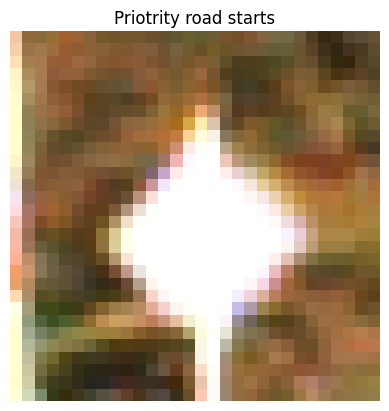

prediction set: {No entry: 0.9905459880828857, Priotrity road starts: 0.009349759668111801}


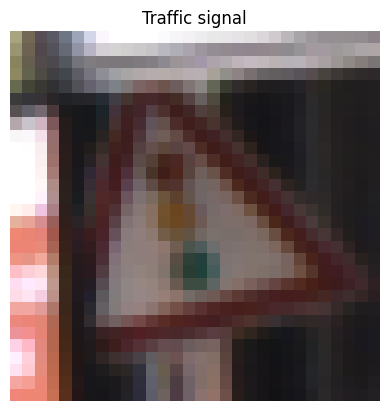

prediction set: {Traffic signal: 0.9600921273231506, Warning: 0.039831504225730896}


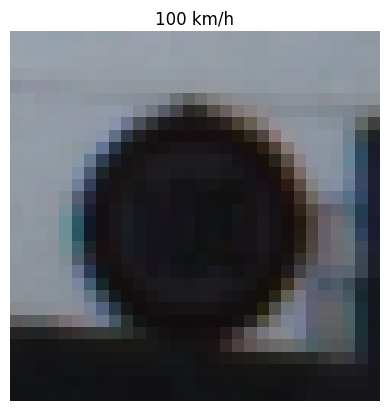

prediction set: {120 km/h: 0.9839661717414856, 100 km/h: 0.016028881072998047}


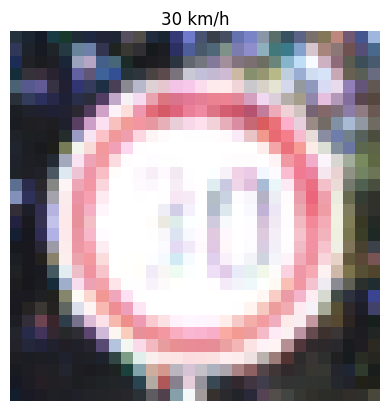

prediction set: {70 km/h: 0.9971863627433777, Drive from the left side of the obstacle: 0.0024868727196007967, 50 km/h: 0.00032101612305268645}


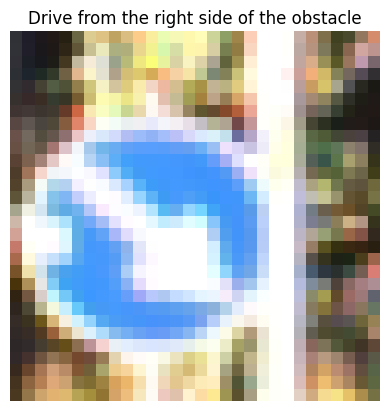

prediction set: {Drive from the left side of the obstacle: 0.9270172715187073, Traffic cirlce: 0.07297767698764801}


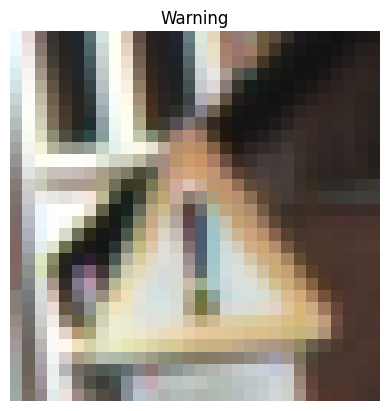

prediction set: {Warning: 0.6826475858688354, Must turn right: 0.1776716262102127, Crosswalk: 0.08219574391841888, Narrows from right: 0.05693725496530533, Traffic cirlce: 0.000383202190278098}


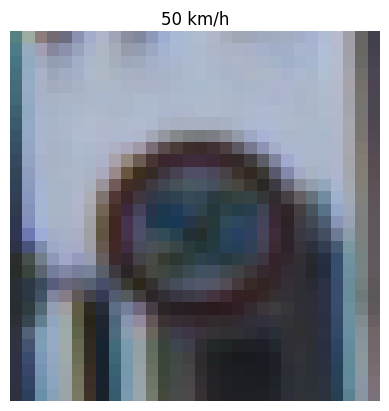

prediction set: {80 km/h: 0.9999997615814209}


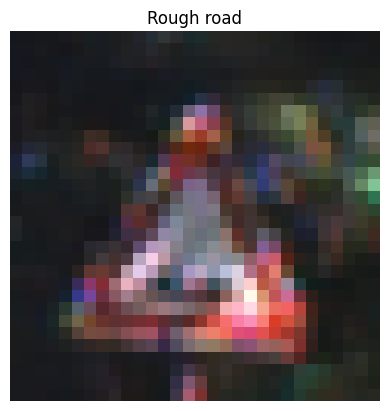

prediction set: {Warning: 0.24727500975131989, Traffic signal: 0.24114829301834106, Be aware of cyclists: 0.1373436599969864, Rough road: 0.1336394101381302, No entry: 0.09805011749267578, Stop: 0.05514534190297127, Be aware of children: 0.022130727767944336, Work in process: 0.014367969706654549, Narrows from right: 0.013507138006389141, yield right-of-way: 0.012107059359550476, 120 km/h: 0.009812431409955025, right turn: 0.0049356515519320965, Must go straight or turn right: 0.00366446515545249, Do not enter: 0.003235116135329008, Priotrity road starts: 0.0015993542037904263, 20 km/h: 0.001353785046376288, 70 km/h: 0.00041145776049233973, Crosswalk: 0.00026538476231507957}


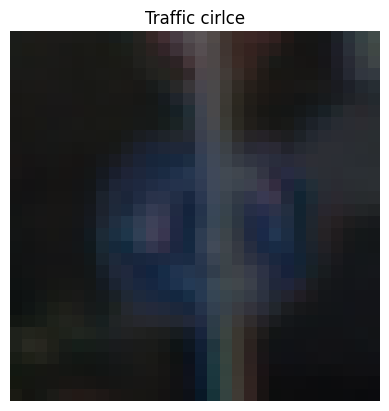

prediction set: {Must go straight or turn left: 0.45257875323295593, Traffic cirlce: 0.3895127475261688, Drive from the left side of the obstacle: 0.07083059847354889, Warning: 0.03478159010410309, Must turn right: 0.031159088015556335, Must go straight: 0.00866785179823637, End of 80 km/h: 0.007986451499164104, End of speed limit: 0.0032132205087691545, Crosswalk: 0.0003914552216883749, Priority at upcoming crossing: 0.00022330890351440758, Drive from the right side of the obstacle: 0.00021379039390012622}


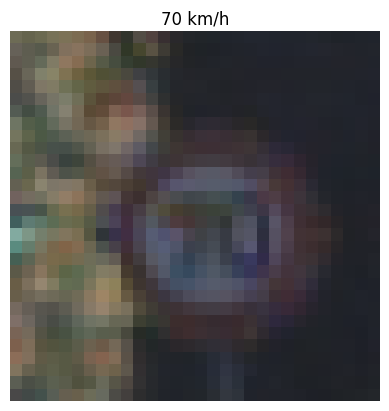

prediction set: {70 km/h: 0.6696386933326721, 30 km/h: 0.3061029314994812, 50 km/h: 0.023993629962205887}


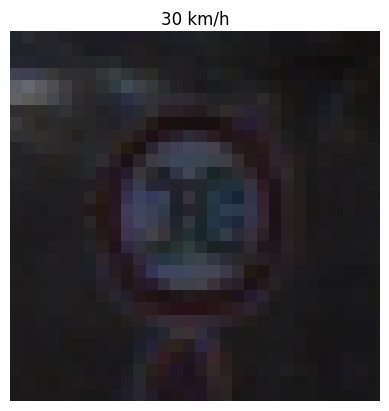

prediction set: {70 km/h: 0.6924200654029846, 30 km/h: 0.3075309991836548}


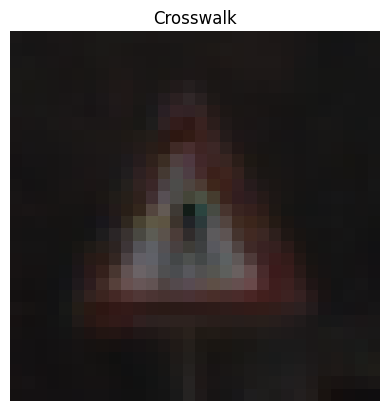

prediction set: {Warning: 0.48729217052459717, Rough road: 0.33329716324806213, Traffic signal: 0.16030824184417725, Be aware of children: 0.01010618731379509, No entry: 0.0035633209627121687, Be aware of cyclists: 0.0031851152889430523, right turn: 0.0008297038730233908, Stop: 0.0006753033376298845, Crosswalk: 0.00026037771021947265}


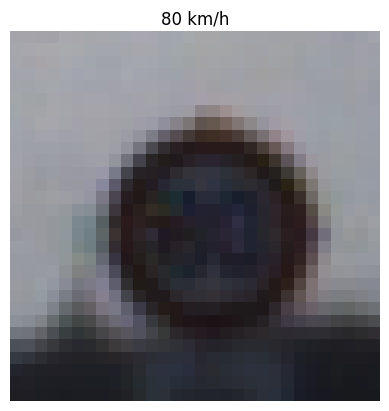

prediction set: {No Passing for vehicles over 3.5t: 0.919508695602417, 80 km/h: 0.04791944846510887, 60 km/h: 0.032544881105422974}


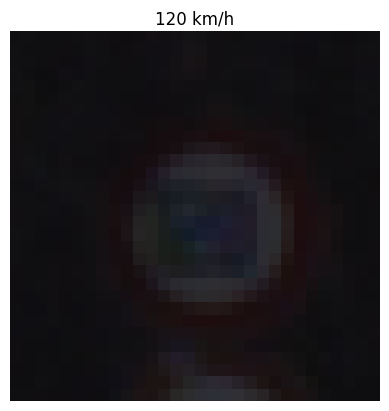

prediction set: {120 km/h: 0.9325246214866638, 100 km/h: 0.06744776666164398}


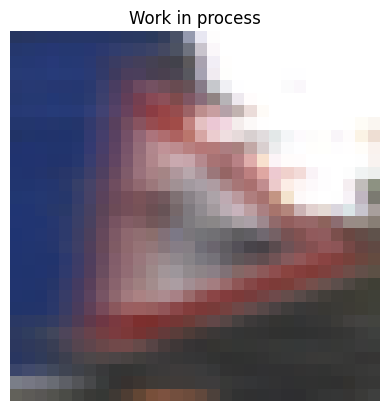

prediction set: {Work in process: 0.9404911398887634, Be aware of wild animals: 0.04986564442515373, double curve - first to left: 0.007159294560551643, Narrows from right: 0.0018718289211392403, Drive from the right side of the obstacle: 0.00028783606830984354, Priority at upcoming crossing: 0.0002336747566005215}


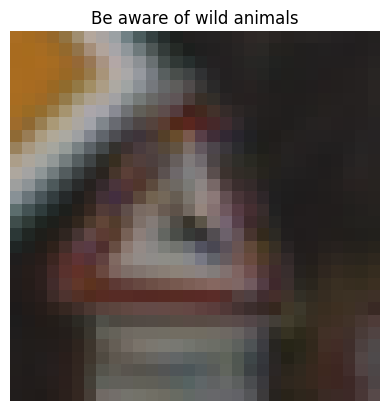

prediction set: {Be aware of wild animals: 0.9877560138702393, No Passing for vehicles over 3.5t: 0.006057069171220064, left turn: 0.0038359789177775383, double curve - first to left: 0.0017938845558091998, 50 km/h: 0.0005560654681175947}


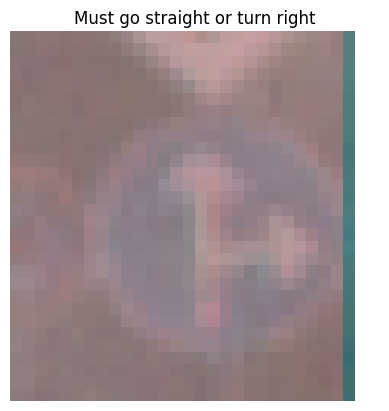

prediction set: {End of 80 km/h: 0.8410856127738953, Must go straight: 0.04243706911802292, 80 km/h: 0.035636093467473984, yield right-of-way: 0.02733592502772808, No Passing for vehicles over 3.5t: 0.013236398808658123, 60 km/h: 0.011074677109718323, right turn: 0.010338802821934223, Drive from the right side of the obstacle: 0.004678547848016024, End of no passing for vehicles over 3.5t: 0.0028777059633284807, Must turn left: 0.002784780226647854, End of no passing: 0.002031766576692462, No Passing: 0.001263134996406734, left turn: 0.0011536325328052044, 50 km/h: 0.0010720548452809453, 100 km/h: 0.001022378564812243, Be aware of wild animals: 0.0008671333780512214, Must go straight or turn left: 0.00022168552095536143}


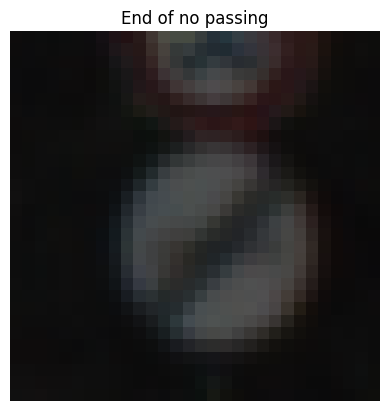

prediction set: {Be aware of children: 0.5015866160392761, Crosswalk: 0.32432395219802856, Priority at upcoming crossing: 0.056201376020908356, right turn: 0.04796035215258598, End of no passing: 0.03941034898161888, Narrows from right: 0.01321993675082922, Be aware of an icy road: 0.008758928626775742, Must turn right: 0.003286628518253565, Warning: 0.0029185055755078793, Traffic cirlce: 0.0013781547313556075, Work in process: 0.0004705492465291172, End of speed limit: 0.0003156112798023969}


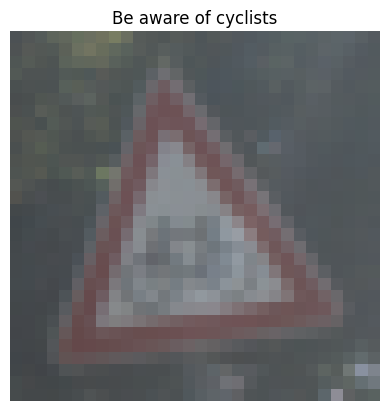

prediction set: {Be aware of children: 0.3376704156398773, Be aware of cyclists: 0.2795380651950836, right turn: 0.21071882545948029, Rough road: 0.10329385101795197, Be aware of an icy road: 0.047151196748018265, Slippery road: 0.021038435399532318, yield right-of-way: 0.00044926407281309366}


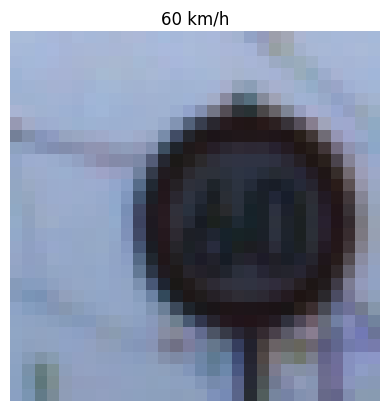

prediction set: {60 km/h: 0.7466015815734863, Stop: 0.12531310319900513, 50 km/h: 0.11584260314702988, yield right-of-way: 0.010385498404502869, No entry: 0.0007110258447937667, 80 km/h: 0.0004036288009956479, 30 km/h: 0.000349982496118173, No Passing: 0.0002276776940561831}


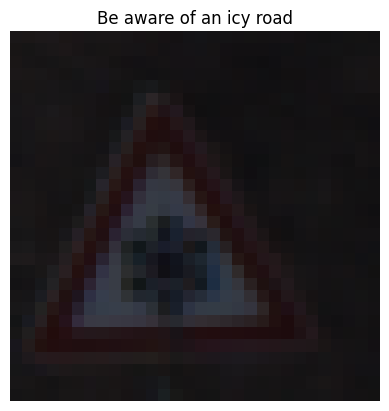

prediction set: {Must go straight: 0.34669041633605957, 60 km/h: 0.3262699544429779, 80 km/h: 0.2758943438529968, yield right-of-way: 0.02652679942548275, No Passing for vehicles over 3.5t: 0.010844334028661251, right turn: 0.009415541775524616, No Passing: 0.0018922515446320176, 50 km/h: 0.0010119996732100844, No entry for vehicles over 3.5t: 0.0008941045380197465, End of 80 km/h: 0.00024033650697674602}


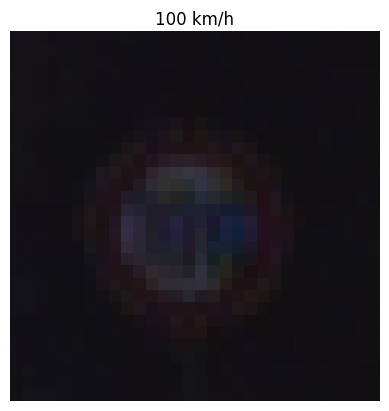

prediction set: {100 km/h: 0.47287917137145996, 80 km/h: 0.3063621520996094, 120 km/h: 0.21936485171318054, 70 km/h: 0.001314860419370234}


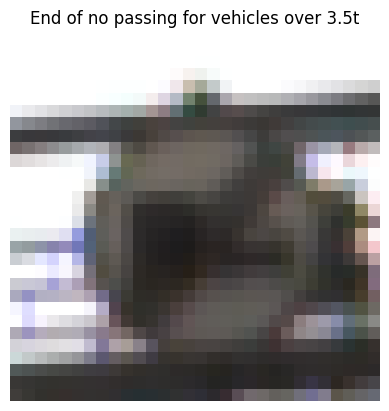

prediction set: {End of no passing for vehicles over 3.5t: 0.9729284048080444, No entry for vehicles over 3.5t: 0.020761406049132347, No Passing for vehicles over 3.5t: 0.005210342817008495, End of 80 km/h: 0.0010954340687021613}


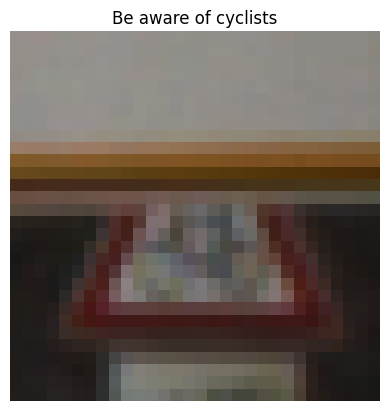

prediction set: {Be aware of an icy road: 0.3350887596607208, Be aware of cyclists: 0.23484690487384796, Narrows from right: 0.16498622298240662, right turn: 0.10348707437515259, Be aware of children: 0.059076011180877686, Slippery road: 0.04558543488383293, Traffic signal: 0.019061526283621788, Warning: 0.011783374473452568, Crosswalk: 0.005901305936276913, Priority at upcoming crossing: 0.00579573679715395, left turn: 0.0049233203753829, Work in process: 0.0038153657224029303, Be aware of wild animals: 0.0035063286777585745, 20 km/h: 0.0009006409673020244, End of no passing for vehicles over 3.5t: 0.0002025405556196347}


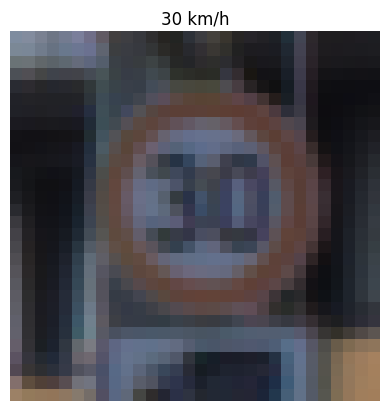

prediction set: {100 km/h: 0.8306710720062256, 80 km/h: 0.13306643068790436, 50 km/h: 0.016078658401966095, 30 km/h: 0.007546161767095327, No entry for vehicles over 3.5t: 0.006416259333491325, No Passing for vehicles over 3.5t: 0.002944957697764039, End of no passing for vehicles over 3.5t: 0.0011930963955819607, 60 km/h: 0.0007564084371551871, End of 80 km/h: 0.0006232796004042029, 120 km/h: 0.00030252226861193776}


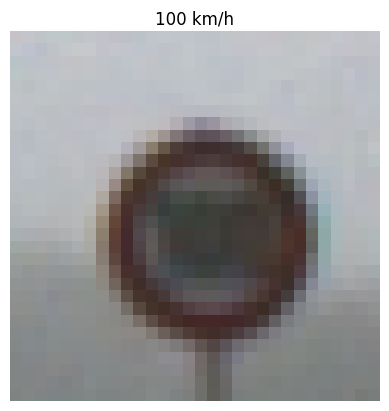

prediction set: {120 km/h: 0.9678675532341003, 100 km/h: 0.032127585262060165}
_________________________________________________________________________________________
We have the probability of 0.8363636363636363 that the true label is in the prediction set with an average prediction set size of 7.672727272727273


In [ ]:
test_smx, _ = get_smx_and_labels(test_loader)
in_set_dist_critical, not_in_set_dist_critical = conformal_prediction(critical_points, testset, test_smx, show_img =  True, print_set = True)

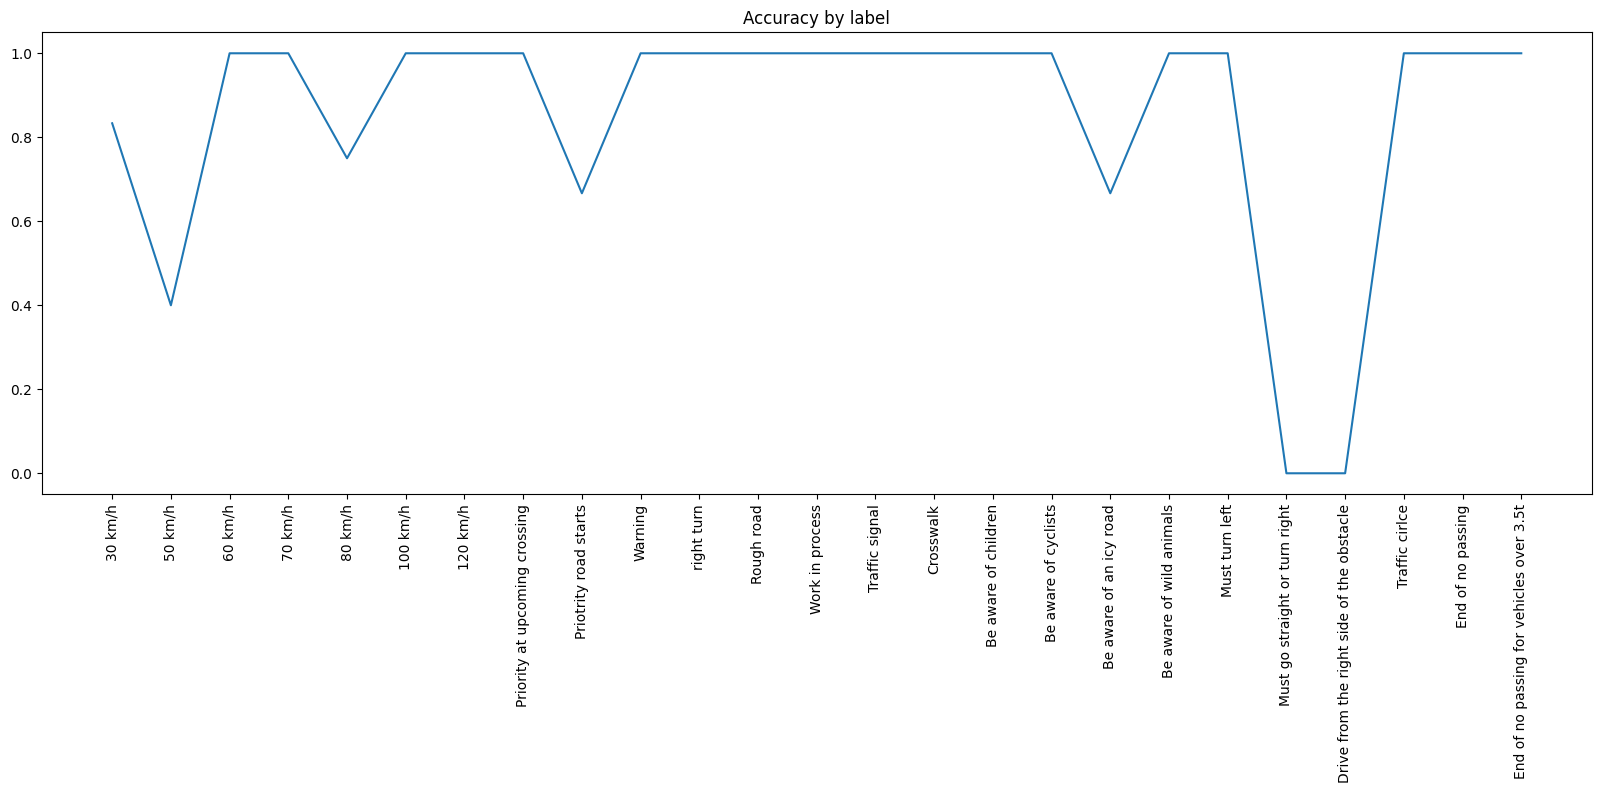

In [ ]:
test_set_critical = torch.utils.data.Subset(testset, indices = critical_points)
test_set_critical_loader = DataLoader(dataset = test_set_critical, batch_size = len(calset), shuffle = False)
test_critical_dist = get_distribution(test_set_critical_loader)
plot_relative_distribution(in_set_dist_critical, test_critical_dist, labels, "Accuracy by label")

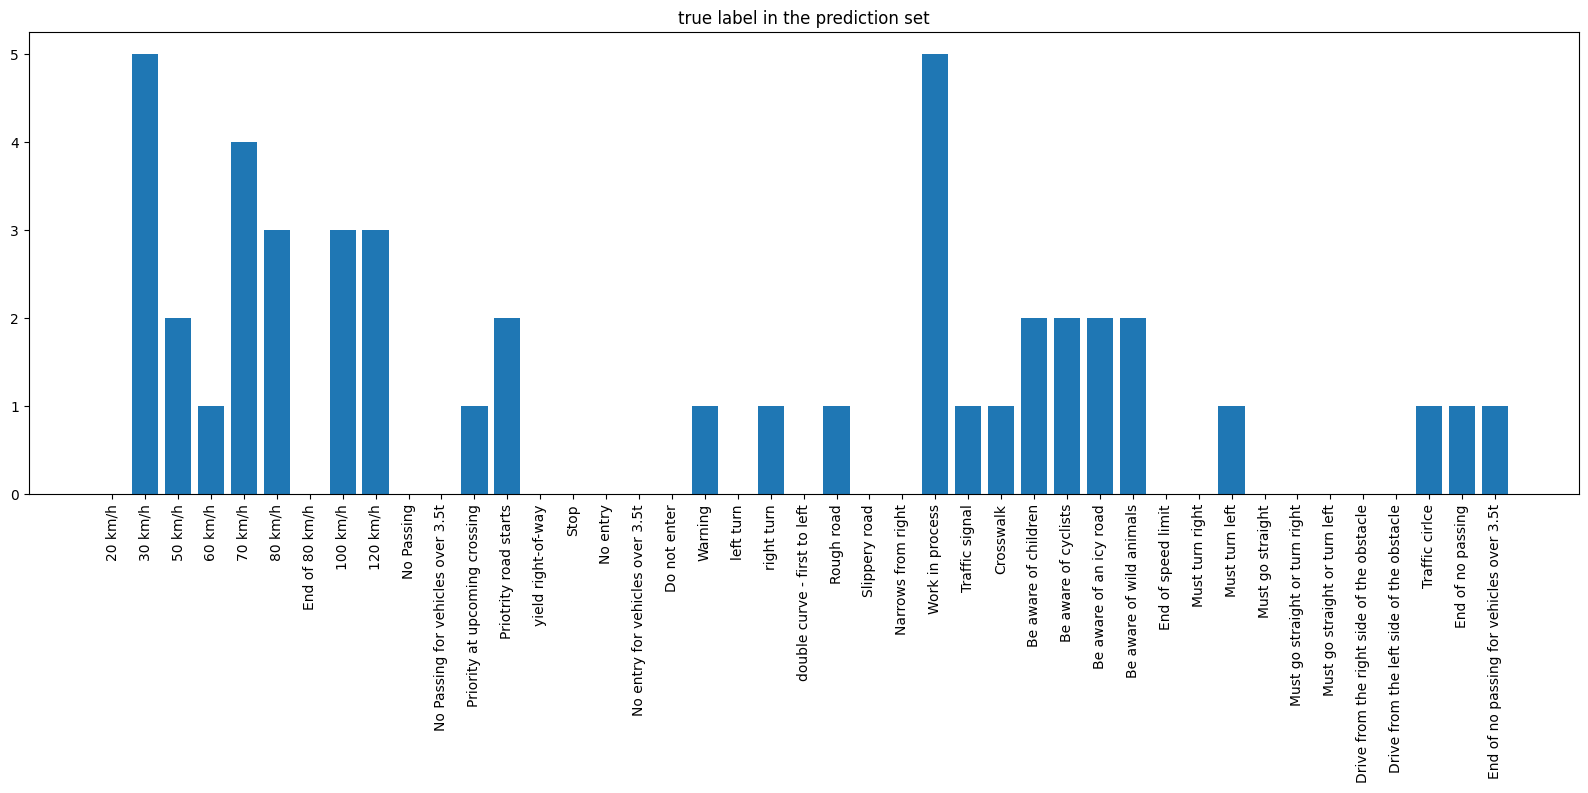

In [ ]:
plot_distribution(in_set_dist_critical, labels, "true label in the prediction set")

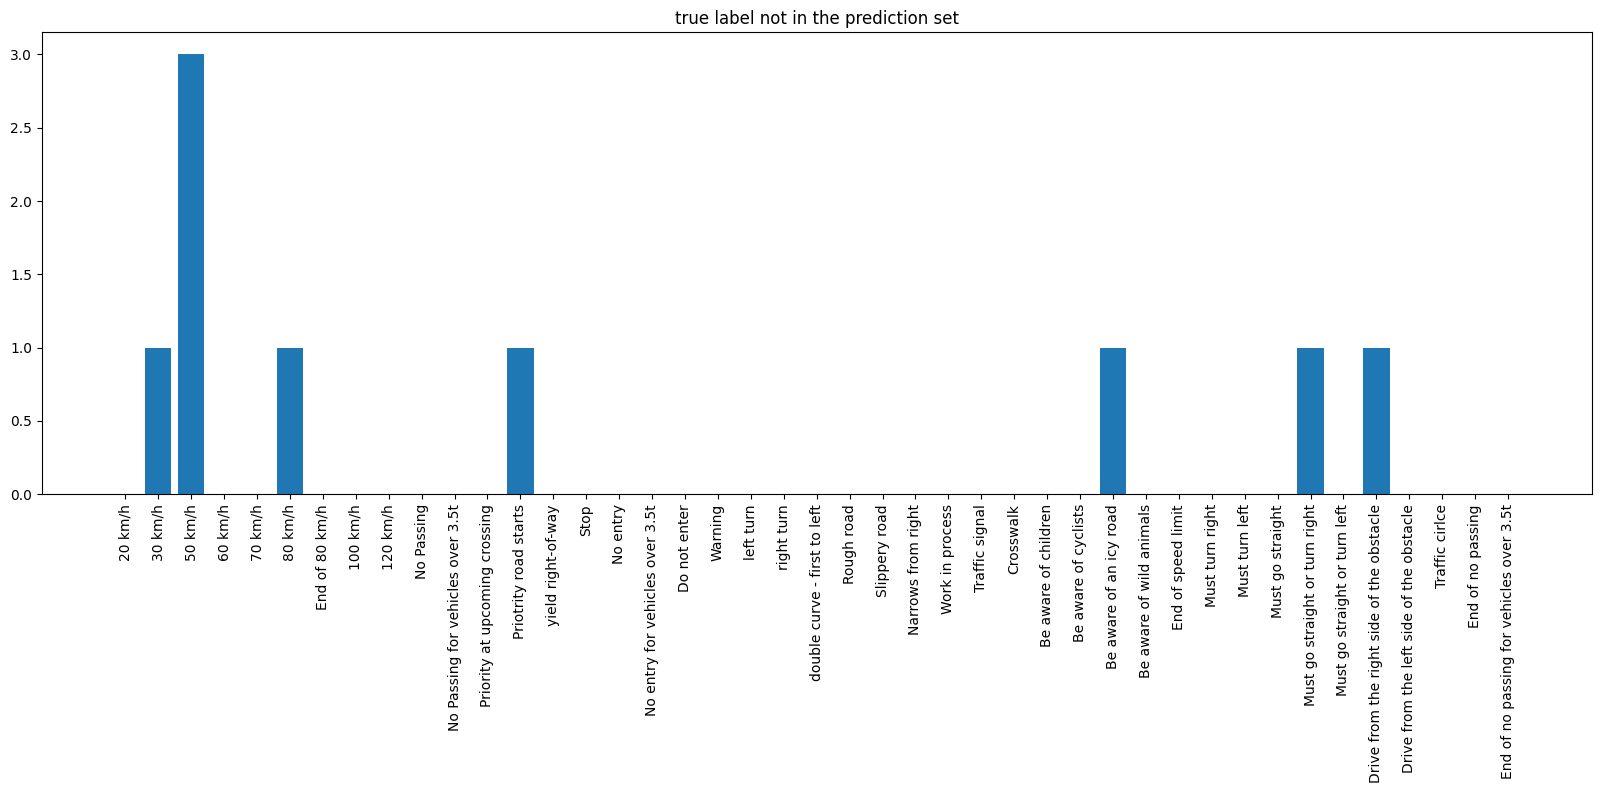

In [ ]:
plot_distribution(not_in_set_dist_critical, labels, "true label not in the prediction set")

# Conformal prediction for the whole validation set

In [ ]:
test_smx, _ = get_smx_and_labels(test_loader)
in_set_dist, not_in_set_dist = conformal_prediction(range(len(testset)), testset, test_smx, show_img = False, print_set = True)

Priotrity road starts                             prediction set: {End of speed limit: 0.5142548680305481, End of no passing: 0.430282324552536, Must turn left: 0.01996450684964657, Must go straight: 0.016048051416873932, Priotrity road starts: 0.0095058623701334, No Passing: 0.0021615184377878904, End of 80 km/h: 0.002121491590514779, Drive from the right side of the obstacle: 0.0017209920333698392, Traffic cirlce: 0.0014003580436110497, End of no passing for vehicles over 3.5t: 0.0011427542194724083, right turn: 0.0009382163407281041, Must go straight or turn right: 0.0003016659466084093}
Slippery road                                     prediction set: {Slippery road: 1.0}
End of 80 km/h                                    prediction set: {End of 80 km/h: 0.9037070274353027, 80 km/h: 0.06372398883104324, 100 km/h: 0.028656205162405968, 60 km/h: 0.0021922977175563574, 50 km/h: 0.0007383279735222459, No Passing for vehicles over 3.5t: 0.0005767860566265881, Must go straight: 0.00023173

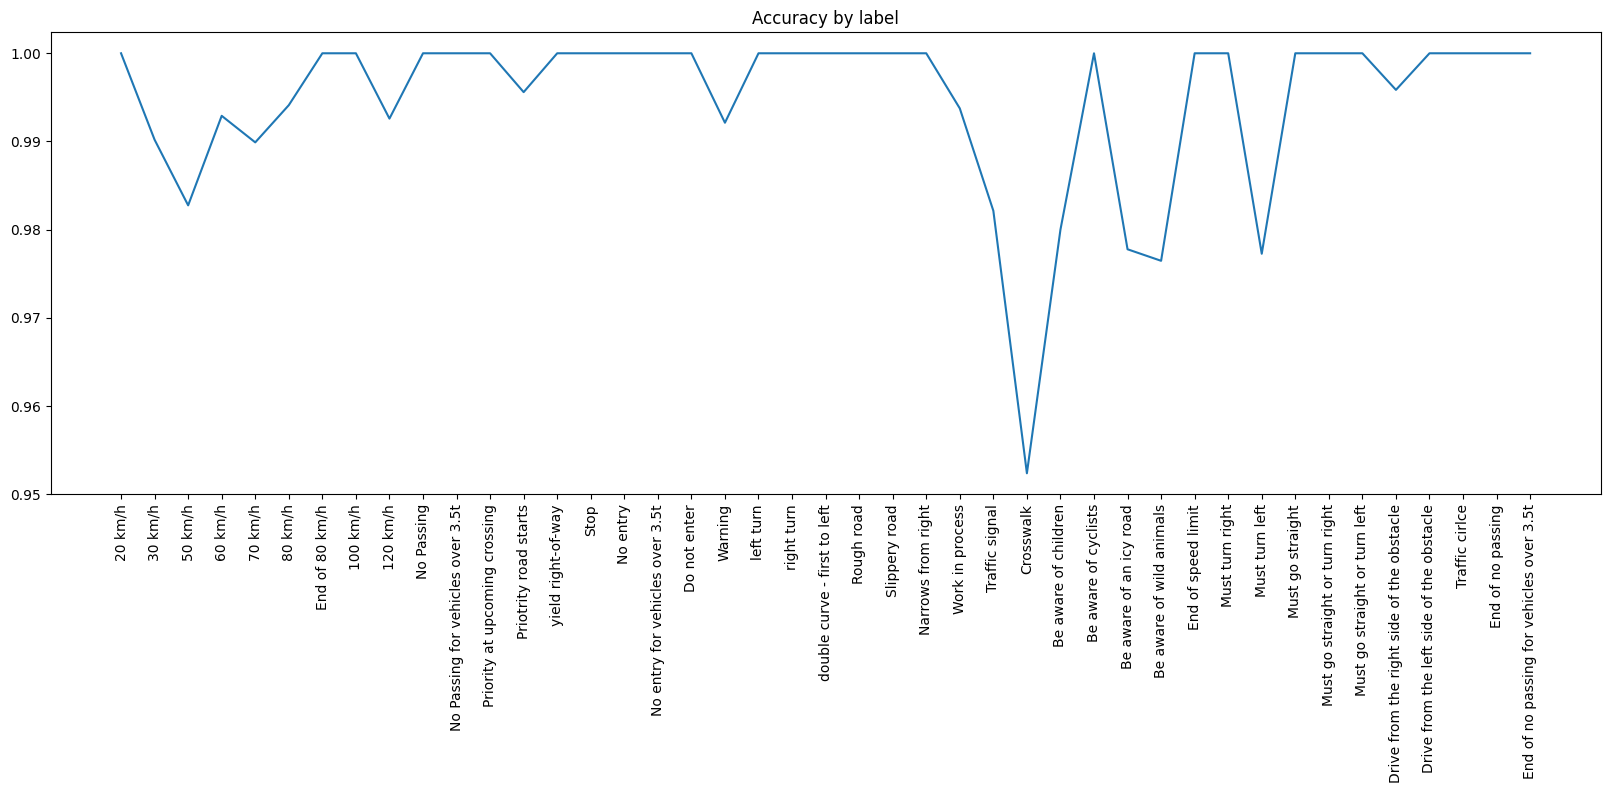

In [ ]:
plot_relative_distribution(in_set_dist, test_dist, labels, "Accuracy by label")

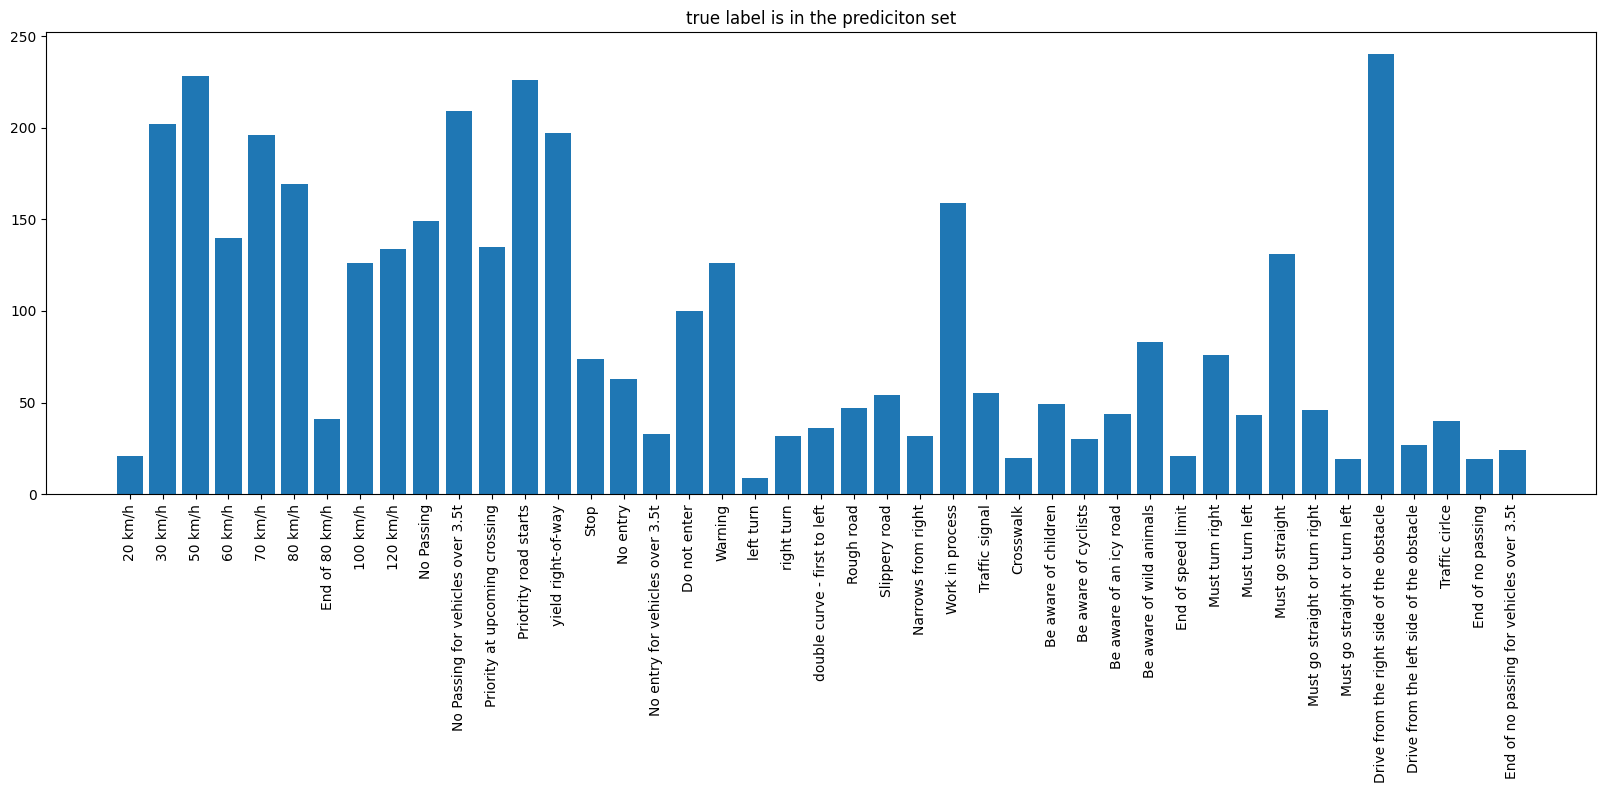

In [ ]:
plot_distribution(in_set_dist, labels, "true label is in the prediciton set")

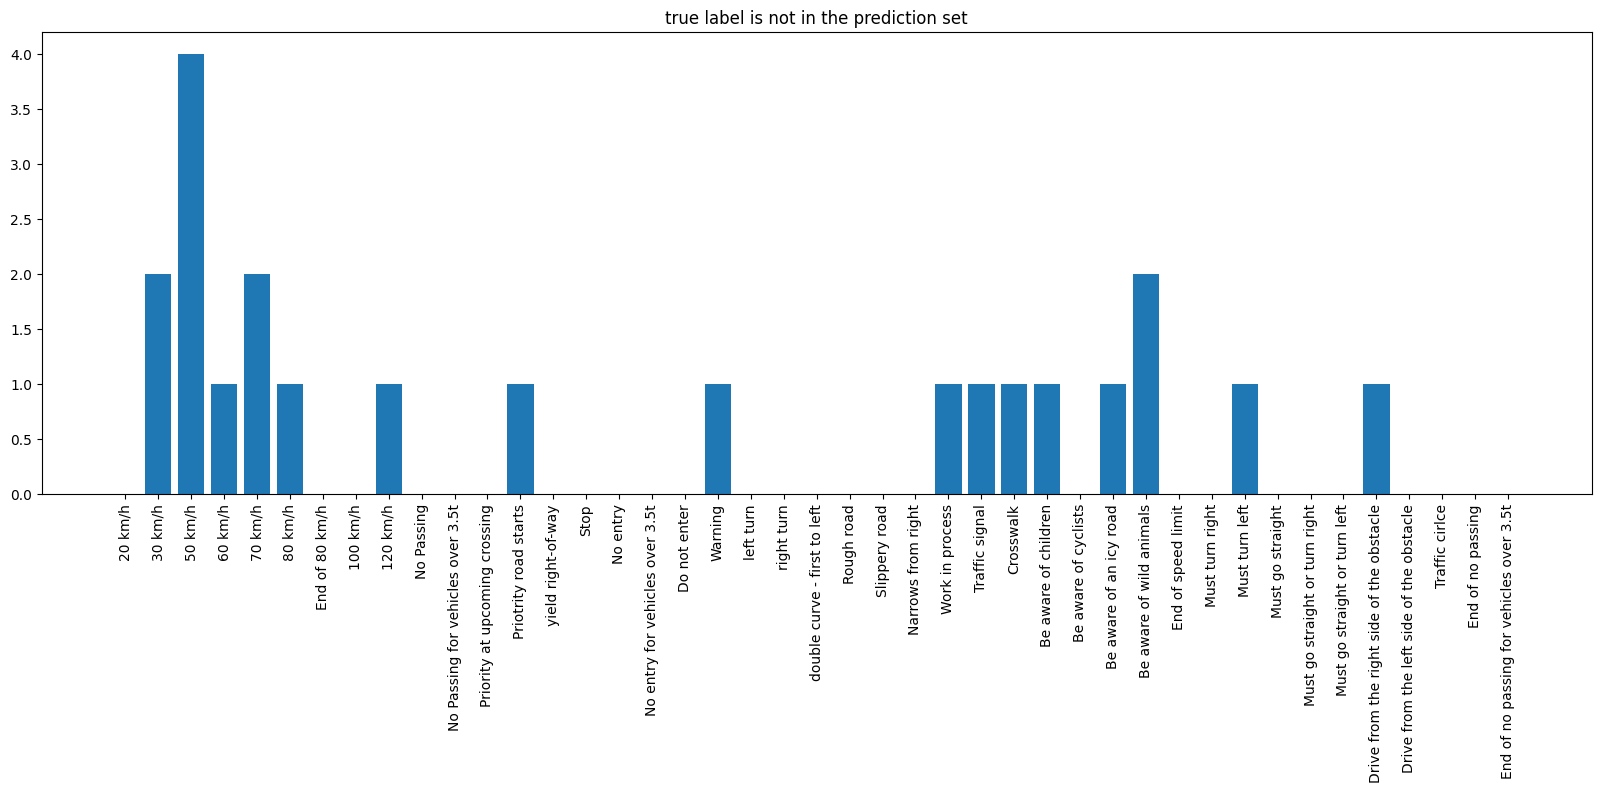

In [ ]:
plot_distribution(not_in_set_dist, labels, "true label is not in the prediction set")

# unfinished

In [ ]:
!unzip /content/gdrive/MyDrive/GtsrbCnn.zip -d /content/GTSRB

Archive:  /content/gdrive/MyDrive/GtsrbCnn.zip
   creating: /content/GTSRB/GtsrbCnn/StopSigns/
   creating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/.DS_Store  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224405.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224408.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224411.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224414.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224418.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224420.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224422.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224435.jpg  
  inflating: /content/GTSRB/GtsrbCnn/StopSigns/AdvStopGTSRB/R20200523_224437.jpg  
  inflating: /content/GTS

In [ ]:
adversarial_dataset = datasets.ImageFolder('/content/GTSRB/GtsrbCnn/StopSigns', transform=data_transforms)

In [ ]:
def conformal_prediction_stop(idx, data, data_smx, show_img = True, print_set = True):

  in_set_distribution = [0 for i in range(num_classes)]
  not_in_set_distribution = [0 for i in range(num_classes)]

  prediction_sets = get_prediction_sets(data_smx, q_hat)
  in_set = 0.0

  for i in idx:
    img, _ = data[i]
    true_label_id = 14

    if show_img:
      plt.title("True label: " + labels[true_label_id])
      plt.axis("off")
      img = img.swapaxes(0,1)
      img = img.swapaxes(1,2)
      plt.imshow(img.squeeze(), cmap="gray")
      plt.show()

    prediction_set = prediction_sets[i]

    if print_set:
      if get_in_set(prediction_set, true_label_id):
        s = Fore.GREEN + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
      else:
        s = Fore.RED + "prediction set" + Style.RESET_ALL + ": " + Fore.WHITE+ "{"
    t = True

    for j, b in enumerate(prediction_set):

      if b:
        label_string = labels[j]

        if label_string == labels[true_label_id]:
          in_set += 1.0
          in_set_distribution[j] += 1
          if print_set:
            label_string = Style.BRIGHT + Fore.YELLOW + labels[j] + Style.RESET_ALL + Fore.WHITE
        else:
          not_in_set_distribution[j] += 1

        if print_set:
          if t:
            s = s + label_string + ": " + str(data_smx[i][j])
            t = False
          else:
            s = s + ", " + label_string + ": " + str(data_smx[i][j])

    if print_set:
      if show_img:
        print(s+"}")
      else:
        space = ""
        for i in range(50 - len(labels[true_label_id])):
          space += " "
        print(labels[true_label_id] + space + s+"}")
  print("_________________________________________________________________________________________")
  print("We have a confidence of "+ Fore.RED + str(in_set/len(idx)) + Style.RESET_ALL +" that the true label is in the prediction set with an average prediction set size of "+ Fore.RED + str(get_average_prediction_set_size(idx, prediction_sets)) + Style.RESET_ALL)

  return in_set_distribution, not_in_set_distribution

In [ ]:
in_set_dist_critical, not_in_set_dist_critical = conformal_prediction_stop(range(len(adversarial_dataset)), adversarial_dataset, val_smx, show_img =  False, print_set = True)

Stop                                              prediction set: {No Passing: 0.12717826664447784, No entry for vehicles over 3.5t: 0.0038787624798715115, End of speed limit: 0.15409742295742035, Must go straight: 0.06424418836832047, End of no passing: 0.6505658626556396}
Stop                                              prediction set: {Slippery road: 1.0}
Stop                                              prediction set: {30 km/h: 0.00013406090147327632, End of 80 km/h: 0.9994345307350159, End of no passing for vehicles over 3.5t: 0.0003670906589832157}
Stop                                              prediction set: {Do not enter: 0.9999998807907104}
Stop                                              prediction set: {30 km/h: 0.03819012641906738, 70 km/h: 0.9618028402328491}
Stop                                              prediction set: {End of no passing for vehicles over 3.5t: 1.0}
Stop                                              prediction set: {Must go straight or turn left

In [ ]:
n = 500
alpha = 0.001

smx = []
labels = []

# generate softmax for calibration data
with torch.no_grad():
    for inputs, classes in cal_loader:
      inputs = inputs.to(device=device)
      classes = classes.to(device=device)
      cv_model.eval()
      smx.extend(model(inputs).softmax(dim=1).detach().cpu().numpy())
      classes = classes.data.cpu().numpy()
      labels.extend(classes)
smx = np.array(smx)
labels = np.array(labels)

# split softmax scores into calibration and validation
idx = np.array([1] * n + [0] * (smx.shape[0]-n)) > 0
np.random.seed(42)
np.random.shuffle(idx)
cal_smx, val_smx = smx[idx,:], smx[~idx,:]
cal_labels, val_labels = labels[idx], labels[~idx]

In [ ]:
# 1: get conformal scores. n = calib_Y.shape[0]
cal_scores = 1-cal_smx[np.arange(n),cal_labels]
# 2: get adjusted quantile
q_level = np.ceil((n+1)*(1-alpha))/n
qhat = np.quantile(cal_scores, q_level, method='higher')
# 3: form prediction sets
prediction_sets = val_smx >= (1-qhat)


In [ ]:
# Calculate empirical coverage
empirical_coverage = prediction_sets[np.arange(prediction_sets.shape[0]),val_labels].mean()
print(f"The empirical coverage is: {empirical_coverage}")

In [ ]:
# Prints prediction sets vs ground truth
for i in range(100):
  k = np.random.uniform(low=0, high=len(val_smx), size=1)
  print([j for j, x in enumerate(prediction_sets[int(k)]) if x], val_labels[int(k)])

**TODO:**
1.   Conformal Prediction
2.   Model Performace Measures (Confusion Matrix, ...)
3.   Dropout Layers
4.   Weights & Biases
5.   Visualization






